In [1]:
# what we see now is like a dim image in a mirror
import os
import json
import glob
import lzma
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import operator
from functools import reduce
from itertools import product
from scipy.ndimage import measurements

import tensorflow as tf

SEED = 420

LOG_DIR = os.path.join('../models', 'train_log')
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training')
EVAL_DIR = os.path.join(DATA_DIR, 'evaluation')
TEST_DIR = os.path.join(DATA_DIR, 'test')

df_sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

train_ids = [fn.split('.json')[0] for fn in os.listdir(TRAIN_DIR)]
eval_ids = [fn.split('.json')[0] for fn in os.listdir(EVAL_DIR)]
test_ids = [fn.split('.json')[0] for fn in os.listdir(TEST_DIR)]
eval_ids = list(set(eval_ids).difference(test_ids))

train_filepaths = glob.glob(TRAIN_DIR + '/*')
eval_filepaths = [os.path.join(EVAL_DIR, f'{t}.json') for t in eval_ids]
test_filepaths = glob.glob(TEST_DIR + '/*')

id_to_filepath = {}

for task_id in train_ids:
    id_to_filepath[task_id] = os.path.join(TRAIN_DIR, f'{task_id}.json')
for task_id in eval_ids:
    id_to_filepath[task_id] = os.path.join(EVAL_DIR, f'{task_id}.json')

In [432]:
def load_task(filepath, verbose=0):
    if verbose:
        task_id = filepath.split('/')[-1].split('.json')[0]
        group = filepath.split('/' + task_id)[0].split('/')[-1]
        print(f"Loading {group} task {task_id}")
    with open(filepath, 'r') as f:
        task = json.load(f)
    return task

def load_task_from_id(task_id):
    task_filename = f'{task_id}.json'
    task_filepath = None
    for root in [TRAIN_DIR, EVAL_DIR, TEST_DIR]:
        if task_filename in os.listdir(root):
            task_filepath = os.path.join(root, task_filename)
    if task_filepath is None:
        raise ValueError(f'`task_id` {task_id} not found.')
    return load_task(task_filepath)

def strip_task(filepath):
    return filepath.split('/')[-1].split('.json')[0]
        

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def unflattener(str_pred):
    pred = []
    for row in str_pred.strip('|').split('|'):
        pred.append([int(row[i]) for i in range(len(row))])
    return np.array(pred, dtype=np.uint8)

# https://github.com/fchollet/ARC/blob/master/apps/css/common.css
NUM_SYMBOLS = 10
COLORS = [
    '#000000',
    '#0074D9',
    '#FF4136',
    '#2ECC40',
    '#FFDC00',
    '#AAAAAA',
    '#F012BE',
    '#FF851B',
    '#7FDBFF',
    '#870C25',
]

idx_to_color = {
    0: 'black',
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'yellow',
    5: 'grey',
    6: 'pink',
    7: 'orange',
    8: 'light blue',
    9: 'brown',
}

color_to_idx = {v: k for k, v in idx_to_color.items()}

idx_to_hex = {
    0: '#000000',
    1: '#0074D9',
    2: '#FF4136',
    3: '#2ECC40',
    4: '#FFDC00',
    5: '#AAAAAA',
    6: '#F012BE',
    7: '#FF851B',
    8: '#7FDBFF',
    9: '#870C25',
}

cmap = colors.ListedColormap(COLORS)
norm = colors.Normalize(vmin=0, vmax=9)
grid_params = {
    'cmap': cmap,
    'norm': norm
}

def generate_idx_to_rgb(hex_list):
    idx_to_rgb = {}
    for i, color in enumerate(hex_list):
        h = color.strip('#')
        rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
        idx_to_rgb[i] = rgb
    return idx_to_rgb

idx_to_rgb = generate_idx_to_rgb(COLORS)

In [3]:
################################################################################
# plot functions
################################################################################

def plot_grid(x, 
              output_shape=None,
              ax=None,
              use_ticks=True,
              title=None,
              lw=.75,
              **kwargs):
    kwargs = dict(grid_params, **kwargs)
    x = np.asarray(x)
    
    if output_shape is not None:
        x = unpad(x, output_shape)
        
    ax = ax or plt.axes()
    p = ax.imshow(x, **kwargs)
    
    if title is not None:
        ax.set_title(title, size=12)
    if use_ticks:
        ax.set_xticks(list(range(x.shape[1])))
        ax.set_yticks(list(range(x.shape[0])))
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    if lw > 0:
        [ax.axvline(i+0.5, c='#555', lw=lw) for i in range(x.shape[1])]
        [ax.axhline(i+0.5, c='#555', lw=lw) for i in range(x.shape[0])]
    
    return p
    
    
def plot_grids(x, cmaps=None, mask_th=0, num_grids=8):
    num_samples = len(x)
    if num_grids < num_samples:
        indices = np.random.choice(range(num_samples), 
                                   num_grids,
                                   replace=False)
    else:
        indices = range(num_samples)
        num_grids = num_samples
    
    fig, ax = plt.subplots(1, 
                           num_grids, 
                           figsize=(num_grids * 5, num_grids * 4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax if isinstance(ax, np.ndarray) else [ax]
    
    for i, idx in enumerate(indices):
        x_grid = x[idx]
        if cmaps is not None:
            x_grid = channel_to_grid(x_grid, cmaps[idx], mask_th)
        plot_grid(x_grid, ax=ax[i])
    
    plt.show();
    
    
def plot_gradient(x, ax=None, show_color_bar=True):
    ax = ax or plt.axes()
    p = ax.imshow(x)
    
    if show_color_bar:
        fig = ax.get_figure()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(p, cax=cax)
    
    ax.set_xticks(list(range(x.shape[1])))
    ax.set_yticks(list(range(x.shape[0])))
    [ax.axvline(i+0.5, c='#555', lw=.5) for i in range(x.shape[1])]
    [ax.axhline(i+0.5, c='#555', lw=.5) for i in range(x.shape[0])];
    
    return ax

    
def plot_task(task, pred_fn=None, task_id=None, **kwargs):
    """Plots the train and test input & outputs for a `task`."""
    num_train = len(task['train'])
    num_test = len(task['test'])
    num_rows = 3 if pred_fn else 2
    N = num_train + num_test
    
    fig, ax = plt.subplots(num_rows, 
                           N, 
                           figsize=(6 * N, 12), 
                           dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    if task_id is not None:
        print(task_id)
    
    for i in range(num_train):
        x_grid = np.array(task['train'][i]['input'])
        y_grid = np.array(task['train'][i]['output'])

        plot_grid(x_grid, ax=ax[0][i], title=f'train_{i} in', **kwargs)
        plot_grid(y_grid, ax=ax[1][i], title=f'train_{i} out', **kwargs)
        
        if pred_fn is not None:
            y_pred = pred_fn(x_grid)
            plot_grid(y_pred, ax=ax[2][i], title=f'train_{i} pred', **kwargs)
        
    for i in range(num_test):
        x_grid = np.array(task['test'][i]['input'])
        plot_grid(x_grid, ax=ax[0][num_train+i], title=f'test_{i} in', **kwargs)
        
        if task['test'][i].get('output'):
            y_grid = np.array(task['test'][i]['output'])
            plot_grid(y_grid, ax=ax[1][num_train+i], title=f'test_{i} out', **kwargs)
        
        if pred_fn is not None:
            y_pred = pred_fn(x_grid)
            plot_grid(y_pred, ax=ax[2][num_train+i], title=f'test_{i} pred', **kwargs)
        
    plt.show()
    
    
def get_input_output(samples):
    x_grids = []
    y_grids = []
    for i in range(len(samples)):
        x_grids.append(np.array(samples[i]['input']))
        if samples[i].get('output'):
            y_grids.append(np.array(samples[i]['output']))
        
    return x_grids, y_grids

def score_task(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
#     if y_true.shape != y_pred.shape:
#         raise ValueError("Output and prediction shapes don't match. "
#                         f"Expected {y_true.shape}, got {y_pred.shape}")
    
    score = np.sum(y_true == y_pred) / y_pred.size
    return score


def score_tasks(y_true, y_pred):
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_pred, list):
        y_pred = [y_pred]
    return np.mean([score_task(y_true[i], y_pred[i]) for i in range(len(y_true))])


def solve_task_symbolic(task, solve_fn, plot_task=True, **kwargs):
    train_samples = task['train']
    test_samples = task['test']

    num_train = len(train_samples)
    num_test = len(test_samples)
    N = num_train + num_test
    
    if plot_task:
        fig, ax = plt.subplots(3, 
                               N, 
                               figsize=(6 * N, 12), 
                               dpi=50)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

    is_scores = []
    oos_scores = []
    oos_preds = []

    for i in range(num_train):
        x_train = train_samples[i]['input']
        y_train = train_samples[i]['output']
        y_pred = solve_fn(x_train)
        is_scores.append(score_task(y_train, y_pred))
        
        if plot_task:
            plot_grid(x_train, ax[0][i], title=f'train_{i} in', **kwargs)
            plot_grid(y_train, ax[1][i], title=f'train_{i} out', **kwargs)
            plot_grid(y_pred, ax[2][i], title=f'train_{i} pred', **kwargs)
    
    for i in range(num_test):
        x_test = test_samples[i]['input']
        y_pred = solve_fn(x_test)
        
        if plot_task:
            plot_grid(x_test, ax[0][num_train+i], title=f'test_{i} in', **kwargs)
            plot_grid(y_pred, ax[2][num_train+i], title=f'test_{i} pred', **kwargs)

        if test_samples[i].get('output'):
            y_test = test_samples[i]['output']
            oos_scores.append(score_task(y_test, y_pred))
            if plot_task:
                plot_grid(y_test, ax[1][num_train+i], title=f'test_{i} out', **kwargs)

        oos_preds.append(y_pred)
        
    
    print(f'IS acc  : {np.mean(is_scores):.4f}')
    if len(oos_scores) > 0:
        print(f'OOS acc : {np.mean(oos_scores):.4f}')
    
    return np.array(oos_preds)


def plot_numeric(x, bold_th=None, figsize=None):
    h,w = x.shape
    s = 1
    figsize = figsize or (int(w*.8),int(h*.8))
    
    bold_th = bold_th or 0
    
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(0, h*s+1)
    ax.set_xlim(0, w*s+1)
    
    for i in range(0, h*s, s):
        for j in range(0, w*s, s):
            v = x[i//s,j//s]
            weight = 'bold' if v > bold_th else None
            ax.text(j+.5, h-i+.5, f' {v:.3f} ', weight=weight)

    ax.set(frame_on=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [4]:
################################################################################
# dataframe utils
################################################################################
def display_row(s):
    if len(s) == 1 & isinstance(s, pd.DataFrame):
        s = s.iloc[0]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(s)

def loc_all(conditions):
    return reduce(operator.and_, conditions, True)

def loc_any(conditions):
    return reduce(operator.or_, conditions, True)

def subset_df(df, conditions, how='all'):
    if how == 'any':
        return df.loc[loc_any(conditions(df))]
    else:
        return df.loc[loc_all(conditions(df))]

################################################################################
# non essential functions
################################################################################
def compute_objs(x, background_color=None):
    x = np.asarray(x)
    if background_color:
        _x = np.ravel(x[0]).tolist()
        background_color = max(set(_x), key=_x.count)
    else:
        background_color = 0
    return measurements.label(x != background_color)[1]

def frequency(x, value):
    return np.ravel(x).tolist().count(value)

def most_common(x):
    _x = np.ravel(x).tolist()
    return max(set(_x), key=_x.count)
    
def compute_objectness(x):
    x = np.asarray(x)
    bkgr_color = most_common(x)
    num_bkgr_color = frequency(x, bkgr_color)
    num_objs = measurements.label(x != bkgr_color)[1]
    return num_objs, bkgr_color, num_bkgr_color


In [394]:
################################################################################
# geometric functions (objects)
################################################################################

def get_dims(x):
    """Returns the (b)atch, (h)eight, (w)idth, and (d)epth of an array/tensor."""
    ndim = len(x.shape) # in the case of a tensor
    if ndim == 2:
        return (0, *x.shape, 0)
    elif ndim == 4:
        return x.shape
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")
        
        
def identity(x):
    return x

def transpose(x):
    b, h, w, d = get_dims(x)
    if b == 0:
        xt = np.zeros((w, h), dtype=np.uint8)

        for i in range(w):
            for j in range(h):
                xt[i][j] = x[j][i]
        return xt
    else:
        xt = np.zeros((b, w, h, d), dtype=np.uint8)
        for i in range(w):
            for j in range(h):
                xt[:,i,j,:] = x[:,j,i,:]
        return xt

def rot90(x):
    b, h, w, d = get_dims(x)
    if b == 0:
        return np.array([[x[h-1-i, j] for i in range(h)] for j in range(w)])
    else:
        return np.moveaxis(
            [[x[:, h-1-i, j, :] for i in range(h)] for j in range(w)], 
            source=2, 
            destination=0
        )

def flip_x(x):
    b, h, w, d = get_dims(x)
    if b == 0:
        return np.array([[x[i,w-1-j] for j in range(w)] for i in range(h)])
    else:
        return np.moveaxis(
            [[x[:,i,w-1-j,:] for j in range(w)] for i in range(h)], 
            source=2, 
            destination=0
        )

def flip_y(x):
    xt = x.T
    b, h, w, d = get_dims(x)
    if b == 0:
        return np.array([[xt[i,w-1-j] for j in range(w)] for i in range(h)]).T
    else:
        return np.moveaxis(
            [[xt[:,i,w-1-j,:] for j in range(w)] for i in range(h)], 
            source=2, 
            destination=0
        ).T

def flip_xy(x):
    return flip_y(flip_x(x))

def shift_obj(x, y=None, max_shift=3, pad_value=0.):
    x_shift = []
    y_shift = []
    max_shift = max(max_shift, 1)
    
    b, h, w, d = get_dims(x)
        
    h_indices = np.arange(h)
    w_indices = np.arange(w)

    shift_w = np.random.choice(range(-max_shift+1, max_shift))
    shift_h = np.random.choice(range(-max_shift+1, max_shift))

    h_idx = h_indices[:shift_h] if shift_h < 0 else h_indices[shift_h:]
    w_idx = w_indices[:shift_w] if shift_w < 0 else w_indices[shift_w:]

    hp = (-shift_h, 0) if shift_h < 0 else (0, shift_h)
    wp = (-shift_w, 0) if shift_w < 0 else (0, shift_w)
    x_shift = pad(x[h_idx,:][:,w_idx], hp, wp, pad_value=pad_value)

    if y is not None:
        y_shift = pad(y[h_idx,:][:,w_idx], hp, wp, pad_value=pad_value)
    
    if y is not None:
        return x_shift, y_shift
    else:
        return x_shift


################################################################################
# algorithmic complexity functions
################################################################################

COMPRESSION_METHODS = [
    'lzma',
#     'gzip',
#     'zlib',
#     'bz2'
]

METHOD_TO_BOUND = {
    'lzma': 60,
    'gzip': 21,
    'zlib': 9,
    'bz2': 37
}


def compute_complexity(x, method='lzma'):
    if method not in COMPRESSION_METHODS:
        raise(f'Unrecognized method {method}')
    bound = METHOD_TO_BOUND.get(method, 0)
    
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(x, list):
        x = flattener(x)
    
    bytes_in = x.encode('utf-8')
    num_bytes_out = len(eval(method).compress(bytes_in)) - bound
    return num_bytes_out, num_bytes_out / len(bytes_in)


################################################################################
# object functions 
################################################################################

def compute_object_matrix(x, background_color=0, structure=None):
    object_matrix = np.zeros_like(x, dtype=np.uint8)
    symbols = [s for s in set(np.unique(x)) if s != background_color]
    
    num_labels = 0
    for s in symbols:
        matrix, n = measurements.label(x == s, structure=structure)
        matrix[matrix != 0] += num_labels
        object_matrix = object_matrix + matrix
        num_labels += n
    
    return object_matrix

def compute_symbolic_matrix(x, background_color=0, structure=None):
    if background_color != 0:
        x = np.array(x, copy=True)
        x[x == 0] = -1
        x[x == background_color] = 0
    return measurements.label(x, structure=structure)[0].astype(np.uint8)
    
    symbols = [s for s in set(np.unique(x)) if s != background_color]
    
    num_labels = 0
    for s in symbols:
        matrix, n = measurements.label(x == s, structure=structure)
        matrix[matrix != 0] += num_labels
        object_matrix = object_matrix + matrix
        num_labels += n
    
    return object_matrix


def get_objects(x, background_color=0, f=None, structure=None, method='object'):
    """Returns a list of object coordinates, colors, and shapes.
    
    Applies a function THEN saves off the indices, meta data, etc
    """
    x = np.asarray(x)
    if f is not None:
        x = f(x)
    x_1d = np.ravel(x).tolist()
    
    if method == 'symbolic':
        obj_matrix = compute_symbolic_matrix(x, background_color, structure)
    else:
        obj_matrix = compute_object_matrix(x, background_color, structure)
    
    labels = np.unique(obj_matrix)[1:]
    if len(labels) > 0:
        # construct object with coordinates, colors, and shape (frame)
        objs = []
        for label in labels:
            coords = np.array(list(zip(*np.where(obj_matrix == label))), dtype=np.uint8)
            symbols = x[tuple(zip(*coords))]
            shape = np.ptp(coords, axis=0) + 1
            objs.append(Object(symbols, coords, shape))
    else:
        objs = [identity_object(x)]
        
    for obj in objs:
        if obj.num_blobs > 0:
            obj.find_children(objs)
        
    return objs


def identity_object(x):
    x = np.asarray(x)
    n, m = x.shape
    coords = np.array(list(product(range(n), range(m))), dtype=np.uint8)
    symbols = x.ravel()
    shape = np.array([n,m], dtype=np.uint8)
    return Object(symbols, coords, shape)


def plot_object(symbols, coordinates, shape, **kwargs):
    """Plots an object."""
    xy = coordinates - coordinates.min(axis=0)
    obj = np.zeros(shape, dtype=np.uint8)
    obj[tuple(zip(*xy))] = symbols
    return plot_grid(obj, **kwargs)


def euclidean_distance(a, b):
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**(1/2)

def neighborhood(x, i, j, kernel=None):
    h, w = x.shape
    neighbors = []
    if kernel is None:
        # 0 1 0
        # 1 0 1 
        # 0 1 0
        kernel = np.array([(0, -1), (0, 1), (-1, 0), (1, 0)])
    
    v = x[i, j]
    for ip, jp in kernel:
        if (0 <= i + ip < h) & (0 <= j + jp < w):
            if x[i+ip, j+jp] == v:
                neighbors.append((i+ip,j+jp))
                
    return neighbors


def find_blob(x, start, blob):
    blob.append(start)
    neighbors = neighborhood(x, *start)
    for indice in neighbors:
        if indice not in blob:
            find_blob(x, indice, blob)
    return blob


def find_holes(x, label=1):
    holes = []
    points = []
    blobs = []
    
    x = np.asarray(x)
    h, w = x.shape
    indices = zip(*np.where(x != label))
    
    for indice in indices:
        if indice not in points:
            blob = np.array(find_blob(x, indice, []))
            v_edges = intersection(blob[:,0], {0, h-1})
            h_edges = intersection(blob[:,1], {0, w-1})
            
            if len(v_edges) == 0 and len(h_edges) == 0:
                holes.append(np.unique(blob, axis=0))
            points.extend(list(map(tuple, blob)))
            blobs.append(blob)
    
    return holes, blobs
    
    
def save_obj(fname, obj, **kwargs):
    use_ticks = kwargs.pop('use_ticks', False)
    ax = plot_object(**obj.params, use_ticks=use_ticks, **kwargs)
    ax.figure.tight_layout()
    plt.savefig(fname, bbox_inches='tight', pad_inches=0)
    plt.close(ax.figure)

    
################################################################################
# state functions
################################################################################

from numpy.lib.stride_tricks import as_strided

def tile_array(x, h_factor, w_factor):
    h, w = x.shape
    hs, ws = x.strides
    x_up = as_strided(x, (h, h_factor, w, w_factor), (hs, 0, ws, 0))
    return x_up.reshape(h * h_factor, w * w_factor)


def project_to_2d(w, indices):
    indices = np.asarray(indices, dtype=int)
    output_x = indices // w
    output_y = indices % w
    return output_x, output_y


def project_to_1d(w, coordinates):
    """Returns indices on a 1D vector that correspond to the 2D `coordinates`."""
    coordinates = np.asarray(coordinates, dtype=np.uint8)
    indices = coordinates[:,1] % w + (coordinates[:,0] * w)
    return indices


def matched_filter(x_input, obj, coordinates, shape):
    """Slides a filter (object) across a state and checks for matches."""
    x_input = np.asarray(x_input)
    x_input_1d = x_input.ravel()

    input_h, input_w = x_input.shape
    strided_h = output_h - shape[0] + 1
    strided_w = output_w - shape[1] + 1

    coordinates_scaled = coordinates - coordinates.min(axis=0)
    indices = project_to_1d(output_w, coordinates_scaled)
    matches = []

    # slide the object across every possible region and check for matches
    for i in range(strided_h):
        for j in range(strided_w):
            strided_indices = indices + j + i * output_w
            if all(x_input_1d[strided_indices] == obj):
                matches.append([tuple(map(tuple, coordinates)), tuple(strided_indices)])
    
    return matches


# def get_background_color(x_grids):
#     x_flat = list(map(np.ravel, x_grids))
#     values_inter = reduce(set.intersection, map(set, x_flat))
#     if len(values_inter) == 0:
#         return 0
#     elif len(values_inter) == 1:
#         return list(values_inter)[0]
#     else:
#         return max(values_inter, key=[v for x in x_flat for v in x].count)
    
def get_background_color(x, y):
    if 0 in x or 0 in y:
        return 0
    # compute ratio of color to number of objects with color
    xy = np.concatenate((np.ravel(x), np.ravel(y))).tolist()
    return max(xy, key=xy.count)


################################################################################
# core utils 
################################################################################

def get_seq_elements(iterables):
    seq = []
    elements = []
    
    for iterable in iterables:
        if isinstance(iterable, np.ndarray):
            if iterable.ndim > 1:
                seq.append({tuple(row) for row in iterable})
                elements.extend(list(map(tuple, iterable)))
            else:
                seq.append(set(iterable.tolist()))
                seq.append(iterable.tolist())
        else:
            if not isinstance(iterable, set):
                seq.append(next(map(set, [iterable])))
            else:
                seq.append(iterable)
            elements.extend(list(iterable))
    
    return seq, elements

def intersection(*args):
    """Returns a list of intersected values from a group of iterables
    sorted by the first appearance of an element."""
    seq, elements = get_seq_elements(args)
    return sorted(reduce(set.intersection, seq), key=elements.index)

def union(*args):
    seq, elements = get_seq_elements(args)
    return sorted(reduce(set.union, seq), key=elements.index)

def diff(*args):
    seq, elements = get_seq_elements(args)      
    return sorted(reduce(set.difference, seq), key=elements.index)


def sample_coordinate(n, m, random_state=None):
    if random_state:
        return (random_state.choice(range(n)), random_state.choice(range(m)))
    else:
        return (np.random.choice(range(n)), np.random.choice(range(m)))

################################################################################
# model utils
################################################################################

from tensorflow_core.python.framework.convert_to_constants import convert_variables_to_constants_v2
from google.protobuf.json_format import MessageToDict

def save_model(model, filename, sched=None, **params):
    """Saves model weights and configurations to disk.
    
    Parameters
    ----------
    model : tf.keras.Model
        Model.
    filename : str
        Output path to save model configurations.
    """
    model.save_weights(filename)
    
    if len(params) > 0:
        tensor_params = {k: tf.constant(v.value) for k, v in params.items()}
    else:
        tensor_params = {}

    concrete_fn = model.call.get_concrete_function(
        x=tf.TensorSpec([None, None, None, model.num_channels]), 
        **tensor_params)
    concrete_fn = convert_variables_to_constants_v2(concrete_fn)
    graph_def = concrete_fn.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
    }
    
    with open(f'{filename}.json', 'w') as f:
        json.dump(model_json, f)
        
        
def load_model(ckpt_dir, 
               step,
               num_channels,
               object_filters=None,
               **params):
    model_filepath = glob.glob(os.path.join(ckpt_dir, f'{step:04d}*.json'))
    weights_filepath = model_filepath[0].split('.json')[0]
    model = CAModel(num_channels, object_filters, **params)
    model.load_weights(weights_filepath)
    return model
        
        
def cleanup(min_files=1):
    ckpt_dirs = os.listdir(LOG_DIR)
    for filename in ckpt_dirs:
        filepath = os.path.join(LOG_DIR, filename)
        if len(os.listdir(filepath)) < min_files:
            os.rmdir(filepath)
            
            
            
################################################################################
# loss functions
################################################################################

def mean_squared_error(y_true, y_pred, axis=None):
    if axis is None:
        axis = [-3, -2, -1]
    return tf.reduce_mean(tf.square(y_true-y_pred), axis=axis)

def bernoulli_loss(y_true, y_pred, from_logits=True):
    """Computes the bernoulli loss (log loss) between the targets (input)
    and predictions (reconstruction).
    """
    if from_logits:
        loss = tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_true, logits=y_pred
            ),
            axis=1,
        )
    else:
        loss = - tf.reduce_sum(
            y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred),
            axis=1
        )
    return tf.reduce_mean(loss)

In [6]:
import gzip
import lzma
import zlib
import bz2


def generate_df_meta(task_filepaths):
    """Generates a dataframe of algorithmic complexity scores for each task."""
    df_meta = pd.DataFrame()

    for i, filepath in enumerate(task_filepaths):
        task_id = strip_task(filepath)
        task = load_task(filepath)
        x_train, y_train = get_input_output(task['train'])
        x_test, y_test = get_input_output(task['test'])

        data = {
            'task_id': [task_id],
            'filepath': [filepath],
            'num_train_samples': len(x_train),
            'num_test_samples': len(x_test)
        }
        
        # shape
        train_inp_shape = np.array([x.shape for x in x_train])
        train_out_shape = np.array([x.shape for x in y_train])
        test_inp_shape = np.array([x.shape for x in x_test])
        
        data['train_input_shape_w_uq'] = len(np.unique(train_inp_shape[:,0]))
        data['train_input_shape_w_mode'] = most_common(train_inp_shape[:,0])
        data['train_input_shape_h_uq'] = len(np.unique(train_inp_shape[:,1]))
        data['train_input_shape_h_mode'] = most_common(train_inp_shape[:,1])
        data['train_output_shape_w_uq'] = len(np.unique(train_out_shape[:,0]))
        data['train_output_shape_w_mode'] = most_common(train_out_shape[:,0])
        data['train_output_shape_h_uq'] = len(np.unique(train_out_shape[:,1]))
        data['train_output_shape_h_mode'] = most_common(train_out_shape[:,1])
        
        train_shape_delta = train_inp_shape - train_out_shape
        data['train_shape_delta_w_mean'] = train_shape_delta[:,0].mean()
        data['train_shape_delta_h_mean'] = train_shape_delta[:,1].mean()
        
        data['test_input_shape_w_uq'] = len(np.unique(test_inp_shape[:,0]))
        data['test_input_shape_w_mode'] = most_common(test_inp_shape[:,0])
        data['test_input_shape_h_uq'] = len(np.unique(test_inp_shape[:,1]))
        data['test_input_shape_h_mode'] = most_common(test_inp_shape[:,1])
        
        # objectness
        train_inp_objs = np.array([compute_objectness(x) for x in x_train])
        train_out_objs = np.array([compute_objectness(x) for x in y_train])
        test_inp_objs = np.array([compute_objectness(x) for x in x_test])
        
        data['train_input_bkgr_color_mode'] = np.argmax(np.bincount(train_inp_objs[:,1]))
        data['train_input_bkgr_color_uq'] = len(np.unique(train_inp_objs[:,1]))
        data['train_input_bkgr_color_count_mean'] = np.mean(train_inp_objs[:,2])
        data['train_input_num_objects_mean'] = np.mean(train_inp_objs[:,0])
        data['train_input_num_objects_std'] = np.std(train_inp_objs[:,0])
        
        data['train_output_bkgr_color_mode'] = np.argmax(np.bincount(train_out_objs[:,1]))
        data['train_output_bkgr_color_uq'] = len(np.unique(train_out_objs[:,1]))
        data['train_input_bkgr_color_count_mean'] = np.mean(train_out_objs[:,2])
        data['train_output_num_objects_mean'] = np.mean(train_out_objs[:,0])
        data['train_output_num_objects_std'] = np.std(train_out_objs[:,0])
        
        data['test_input_bkgr_color_mode'] = np.argmax(np.bincount(test_inp_objs[:,1]))
        data['test_input_bkgr_color_uq'] = len(np.unique(train_out_objs[:,1]))
        data['train_input_bkgr_color_count_mean'] = np.mean(test_inp_objs[:,2])
        data['test_input_num_objects_mean'] = np.mean(test_inp_objs[:,0])
        data['test_input_num_objects_std'] = np.std(test_inp_objs[:,0])
        
        # algorithmic complexity
        if len(y_test) > 0:
            test_out_objs = np.array([compute_objectness(x) for x in y_test])
            data['test_output_bkgr_color_mode'] = np.argmax(np.bincount(test_out_objs[:,1]))
            data['test_output_bkgr_color_uq'] = len(np.unique(test_out_objs[:,2]))
            data['test_output_bkgr_color_count_mean'] = np.mean(test_out_objs[:,2])
            data['test_output_num_objects_mean'] = np.mean(test_out_objs[:,0])
            data['test_output_num_objects_std'] = np.std(test_out_objs[:,0])       
        
        for method in COMPRESSION_METHODS:
            
            train_inp_comp = [compute_complexity(x, method) for x in x_train]
            train_out_comp = [compute_complexity(x, method) for x in y_train]
            test_inp_comp = [compute_complexity(x, method) for x in x_test]

            data[f'train_input_bytes_mean_{method}'] = [np.mean(train_inp_comp, 0)[0]]
            data[f'train_input_ratio_mean_{method}'] = [np.mean(train_inp_comp, 0)[1]]
            data[f'train_input_ratio_std_{method}'] = [np.std(train_inp_comp, 0)[1]]
            data[f'train_output_bytes_mean_{method}'] = [np.mean(train_out_comp, 0)[0]]
            data[f'train_output_ratio_mean_{method}'] = [np.mean(train_out_comp, 0)[1]]
            data[f'train_output_ratio_std_{method}'] = [np.std(train_out_comp, 0)[1]]
            data[f'test_input_bytes_mean_{method}'] = [np.mean(test_inp_comp, 0)[0]]
            data[f'test_input_ratio_mean_{method}'] = [np.mean(test_inp_comp, 0)[1]]
            data[f'test_input_ratio_std_{method}'] = [np.std(test_inp_comp, 0)[1]]
            
            
            if len(y_test) > 0:
                test_out_comp = [compute_complexity(y, method) for y in y_test]

                data[f'test_output_bytes_mean_{method}'] = [np.mean(test_out_comp, 0)[0]]
                data[f'test_output_ratio_mean_{method}'] = [np.mean(test_out_comp, 0)[1]]
                data[f'test_output_ratio_std_{method}'] = [np.std(test_out_comp, 0)[1]]
        
        df_meta = pd.concat((df_meta, pd.DataFrame(data)), ignore_index=True)
    
    return df_meta

In [7]:
class ShapeSolver(object):
    """Linear shape solver."""
    def __init__(self):
        self.coef_ = None
        self.w_coef_ = None
        self.h_coef_ = None
        self.n_coef = None
        
    def fit(self, input_shapes, output_shapes):
        input_shapes = np.asarray(input_shapes, dtype=np.uint8)
        output_shapes = np.asarray(output_shapes, dtype=np.uint8)
        n = len(input_shapes)
        
        h_input = np.hstack((np.expand_dims(input_shapes[:,0], axis=1), 
                             np.ones((n, n-1))))
        h_output = output_shapes[:,0]
        
        w_input = np.hstack((np.expand_dims(input_shapes[:,1], axis=1), 
                             np.ones((n, n-1))))
        w_output = output_shapes[:,1]
        
        if np.linalg.det(h_input) == 0:
            self.h_coef_ = np.concatenate(([1], np.zeros(n-1)))
        else:
            self.h_coef_ = np.linalg.solve(h_input, h_output)
        
        if np.linalg.det(w_input) == 0:
            self.w_coef_ = np.concatenate(([1], np.zeros(n-1)))
        else:
            self.w_coef_ = np.linalg.solve(w_input, w_output)
        
        self.coef_ = np.vstack((self.h_coef_, self.w_coef_))
        self.n_coef = self.coef_.shape[1]
        return self
    
    def predict(self, input_shapes):
        input_shapes = np.array(input_shapes, dtype=np.uint8)
        if input_shapes.ndim == 1:
            input_shapes = np.expand_dims(input_shapes, axis=0)
        n = len(input_shapes)
        
        h_input = np.hstack((np.expand_dims(input_shapes[:,0], axis=1), 
                             np.ones((n, self.n_coef-1))))
        w_input = np.hstack((np.expand_dims(input_shapes[:,1], axis=1), 
                             np.ones((n, self.n_coef-1))))
        
        h_output = np.dot(h_input, self.h_coef_)
        w_output = np.dot(w_input, self.w_coef_)
        
        return np.stack((h_output, w_output), axis=1)

In [8]:
class AdapativeParam(object):
    
    def __init__(self, 
                 start_value,
                 factor=.9, 
                 update_f=None,
                 patience=5,
                 mode='min',
                 min_delta=0,
                 cooldown=0,
                 lower_bound=0,
                 upper_bound=np.inf,
                 reset=False,
                 update_params=None,
                 name=None):
        self.start_value = start_value
        self.factor = factor
        self.patience = patience
        if update_f is not None:
            self.update_f = update_f
        else:
            self.update_f = lambda v, factor: v * factor
        self.mode = mode
        self.min_delta = min_delta
        self.cooldown = cooldown
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.reset = reset
        self.name = name
        self.update_params = update_params or {}
        
        self.value = self.start_value
        self.best = None
        self.monitor_op = None
        self.current_step = 0
        self.wait = 0
        self.cooldown_counter = 0
        self.best_step = 0
        self.history = {}
        
        self._reset()
    
    def __repr__(self):
        return f'<{self.__class__.__name__} ({self.name}): {self.value}>'
    
    def __add__(self, other):
        return self.value + other
    
    def __radd__(self, other):
        return self.value + other
    
    def __mul__(self, other):
        return self.value * other
    
    def __rmul__(self, other):
        return self.value * other
    
    def __truediv__(self, other):
        return self.value / float(other)
    
    def __rtruediv__(self, other):
        return float(other) / self.value
    
    def __sub__(self, other):
        return self.value - other
    
    def __rsub__(self, other):
        return other - self.value
    
    def __pow__(self, other):
        return self.value ** other
    
    def __rpow__(self, other):
        return other ** self.value
    
    def __le__(self, other):
        return self.value <= other
    
    def __lt__(self, other):
        return self.value < other
    
    def __ge__(self, other):
        return self.value >= other
    
    def __gt__(self, other):
        return self.value > other
    
    def __eq__(self, other):
        return self.value == other
    
    def __neq__(self, other):
        return self.value != other
    
    def __hash__(self):
        return hash(self.value)
    
    def __array__(self):
        return np.array(self.value)
    
    def _reset(self):
        if self.mode not in ['min', 'max', 'auto']:
            raise ValueError( 'Expected `mode` in (min, max, auto).' 
                             f'got {self.mode}')

        if self.mode == 'max':
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        else:
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        
        self.history['best'] = [self.best]
        self.history['best_step'] = [self.best_step]
        self.history['value'] = [self.value]
    
    def step(self, current, step=None, **kwargs):
        if step is None:
            self.current_step += 1
        
        if self.monitor_op(current, self.best):
            self.best = current
            self.best_step = self.current_step
            self.history['best'].append(self.best)
            self.history['best_step'].append(self.best_step)
            self.history['value'].append(self.value)
            
            self.wait = 0
            self.cooldown_counter = 0
        else:
            self.cooldown_counter += 1
            if self.cooldown_counter > self.cooldown:
                self.wait += 1
                if self.wait > self.patience:
                    new_value = self.update_f(self.value, 
                                              self.factor,
                                              **self.update_params,
                                              **kwargs)
                    if new_value > self.lower_bound and new_value < self.upper_bound:
                        print(f'Updating {self.name} from {self.value} to {new_value} '
                              f'at step {self.current_step}')
                        self.value = new_value
                    elif self.reset:
                        print(f'Resetting {self.name} from {self.value} to '
                              f'{self.start_value} at step {self.current_step}.')
                        self.value = self.start_value
                        
                    self.wait = 0
                    self.cooldown_counter = 0
                    

class Scheduler(object):
    
    def __init__(self, params):
        self.params = params
        self.hist = {}
        
    def get_history(self):
        return self.hist
    
    def get_best(self):
        best_step = np.argmax([v['loss'] for v in self.hist.values()])
        return self.hist[best_step]['params']
        
    def __call__(self, current, step=None, **kwargs):
        self.hist[step] = {'loss': current, 'params': {}}
        for key, param in self.params.items():
            param.step(current, step, **kwargs)
            self.hist[step]['params'][key] = param.value
            
    def __repr__(self):
        _params_str = '\n\t'.join([p.__repr__() for p in self.params.values()])
        return f"<{self.__class__.__name__}: \n\t{_params_str}>"

In [9]:
################################################################################
# grid utility functions
################################################################################

NUM_CHANNELS = len(COLORS)

def grid_to_rgb(x):
    """Returns a 3D array of RGB values of an ARC grid."""
    x_rgb = np.asarray(x)
    if x_rgb.ndim == 2:
        x_rgb = x_rgb[None, ...]
    if x_rgb.ndim == 3:
        x_rgb = x_rgb[..., None]
    
    x_rgb = np.repeat(x_rgb, 3, axis=-1)
    values = np.unique(x_rgb)
    for v in values:
        x_rgb[x_rgb[:,:,:,0] == v] = idx_to_rgb[v]
    return x_rgb[0] if x_rgb.shape[0] == 1 else x_rgb


def grid_to_rgba(x):
    """Returns a 3D array of RGB values of an ARC grid."""
    x = np.asarray(x)
    a = arc_conv2d((x != background_color).astype(np.float32), 
                   kernel=np.ones((3, 3), dtype=np.float32) / 9.,
                   padding='same')
    x_rgb = grid_to_rgb(x)
    x_rgba = np.concatenate([x_rgb, np.expand_dims(a, axis=-1)], axis=-1)
    return x_rgba.astype(np.float32)


def get_alpha(x, kernel=None, background_color=0):
    """Returns a 3D array of RGB values of an ARC grid."""
    x = np.asarray(x, dtype=np.float32)
    ndim = x.ndim
    if ndim == 2:
        x = x[None, ..., None]
    if ndim == 3:
        raise ValueError(f"Expected 2 or 4 dims. Got {ndim}")
        
    if kernel is None:
        kernel = np.ones((3, 3, 1, 1)) / 9.
    else:
        kdim = kernel.ndim
        if kdim == 2:
            kernel = kernel[..., None]
        if kdim == 3:
            kernel = kernel[..., None]
    
    kernel = kernel.astype(np.float32)       
    a = tf.nn.depthwise_conv2d(x, kernel, [1,1,1,1], 'SAME').numpy()
    if ndim == 2:
        return np.clip(a[0,...,0].astype(np.float32), -1, 1.)
    else:
        return np.clip(a.astype(np.float32), -1, 1.)

def grid_to_channel(x, cmap=None, background_color=0):
    """Transforms a 2D grid of color indices to a 3D tensor where each channel
    corresponds to a color.
    """
    x = np.asarray(x)
    if cmap is None:
        cmap = {i: i for i in range(NUM_CHANNELS)}
    
    x_channels = []
    for ch, v in cmap.items():
        if v == background_color:
            x_channels.append(np.zeros_like(x, dtype=np.float32))
        else:
            x_channels.append((x == v).astype(np.float32))
    return np.stack(x_channels, axis=2)     

def channel_to_grid(x, 
                    cmap=None,
                    mask_th=0,
                    num_channels=None,
                    background_color=0):
    """Transforms a binarized 3D matrix to a 2D grid of color indices."""
    x = np.array(x)
    if cmap is None:
        cmap = {i: i for i in range(NUM_CHANNELS)}
    num_channels = len(cmap)
    
    if x.shape[-1] < num_channels + 1:
        x = np.concatenate((x, x.sum(axis=-1)[...,None]), -1)
        
    mask = x[...,-1] > mask_th

    x_grid = np.argmax(x[..., :num_channels], axis=-1)
    x_grid = np.vectorize(cmap.__getitem__)(x_grid)
    x_grid[np.where(mask == 0)] = background_color
    
    return x_grid


def unpad(x, output_shape):
    ndim = len(x.shape)
    if ndim == 2:
        h, w = x.shape
    elif ndim == 4:
        h, w = x.shape[1:3]
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")
    
    hp = h - output_shape[0]
    wp = w - output_shape[1]
    if hp > 0:
        hp = (hp//2, h-hp//2) if hp % 2 == 0 else (hp//2+1, h-hp//2)
    else:
        hp = (0, h)
    if wp > 0:
        wp = (wp//2, w-wp//2) if wp % 2 == 0 else (wp//2+1, w-wp//2)
    else:
        wp = (0, w)
    
    if ndim == 2:
        if isinstance(x, np.ndarray):
            return x[hp[0]:hp[1], wp[0]:wp[1]]
        elif isinstance(x, tf.Tensor):
            return tf.slice(x, [hp[0], wp[0]], [hp[1]-hp[0], wp[1]-wp[0]])
        else:
            raise ValueError(f'Unrecognized data type {type(x)}')
    else:
        if isinstance(x, np.ndarray):
            return x[:,hp[0]:hp[1], wp[0]:wp[1],:]
        elif isinstance(x, tf.Tensor):
            return tf.slice(x, 
                            begin=[0, hp[0], wp[0], 0], 
                            size=[-1, hp[1]-hp[0], wp[1]-wp[0], -1])
        else:
            raise ValueError(f'Unrecognized data type {type(x)}')

def pad(x, hp=0, wp=0, dp=0, pad_value=0):
    ndim = len(x.shape)
    if not isinstance(hp, (list, tuple)):
        hp = (hp, hp)
    if not isinstance(wp, (list, tuple)):
        wp = (wp, wp)
    if not isinstance(dp, (list, tuple)):
        dp = (dp, dp)

    if ndim == 2:
        pad_width = [hp, wp]
    elif ndim == 4:
        pad_width = [(0,0), hp, wp, dp]
    else:
        pad_width = [hp, wp, dp]
    
    if isinstance(x, np.ndarray):
        return np.pad(x, pad_width, constant_values=pad_value)
    elif isinstance(x, tf.Tensor):
        return tf.pad(x, pad_width, constant_values=pad_value)
    else:
        raise ValueError(f'Unrecognized data type {type(x)}')
        
    
def pad_grid(x, output_shape, pad_value=0.):
    h, w = x.shape[:2]
    hp = (output_shape[0] - h)
    wp = (output_shape[1] - w)

    hp = (hp//2,)*2 if hp % 2 == 0 else (hp//2+1, hp//2)
    wp = (wp//2,)*2 if wp % 2 == 0 else (wp//2+1, wp//2)

    return pad(x, hp, wp, pad_value=pad_value)


def arc_conv2d(x_input, kernel, padding='same', strides=1):
    """Slides a filter (object) across a state and checks for matches."""
    x_input = np.asarray(x_input)
    kernel_h, kernel_w = kernel.shape
    
    if padding == 'same':
        hp = kernel_h // 2
        wp = kernel_w // 2
        x_input = np.pad(x_input, [(hp, wp), (hp, wp)])
    
    x_input_1d = x_input.ravel()
    kernel_1d = np.ravel(kernel)
    
    input_h, input_w = x_input.shape
    strided_h = (input_h - kernel_h + 1) // strides
    strided_w = (input_w - kernel_w + 1) // strides
    y_output = np.zeros((strided_h, strided_w), np.float32)

    indices = project_to_1d(input_w, list(product(range(kernel_h), range(kernel_w))))

    # slide the object across every possible region and check for matches
    for i in range(strided_h):
        for j in range(strided_w):
            strided_indices = indices + j + i * input_w
            dot = np.dot(x_input_1d[strided_indices], kernel_1d)
            y_output[i, j] = np.dot(x_input_1d[strided_indices], kernel_1d)
    
    return y_output


################################################################################
# palette functions
################################################################################

def get_palette(x):
    x = np.asarray(x).ravel().tolist()
    return sorted(set(x), key=x.index)

def pal_per_example(examples):
    if examples is None:
        return [{}]
    palettes = []
    for x in examples:
        palettes.append(get_palette(x))
    return palettes

def get_cmap(palette, 
             size=None,
             continuity_symbols=None,
             spatial_symbols=None,
             background_color=0):
    cmap = {}
    ordered_palette = []
    palette = diff(palette, {background_color})
    size = len(palette) if size is None else size
    pal_size = len(palette)
    
    if continuity_symbols is not None:
        for symbol in continuity_symbols:
            if symbol not in ordered_palette:
                ordered_palette.append(symbol)
    
    if spatial_symbols is not None:
        for symbol in spatial_symbols:
            if symbol not in ordered_palette:
                ordered_palette.append(symbol)
    
    # preserves order
    oredered_palette = union(ordered_palette, palette)
    
    for i in range(size):
        if i < pal_size:
            cmap[i] = oredered_palette[i]
        else:
            cmap[i] = background_color
    
    return cmap

################################################################################
# tuning/scheduler utils
################################################################################

def log_scale(x, factor, step=None):
    return x**factor

def duration_fn(x, factor):
    return int(x**factor)

def decay_lr(lr, factor, optim, min_lr=0):
    new_lr = lr * factor
    if new_lr > min_lr:
        optim.lr.assign(new_lr)
    return new_lr


################################################################################
# evaluation functions
################################################################################

def get_pred(x, ch):
    return tf.concat([x[...,:ch], x[...,-1:]], axis=-1)

def generate_predictions(model, 
                         x,
                         cmap, 
                         target=None,
                         dropout=.5,
                         step_size=1.,
                         mask_th=.1,
                         steps=100,
                         verbose=0,
                         output_shape=None,
                         return_best=False):
    y_preds = []
    losses, accs = [], []

    for step in range(steps):
        x = model(x, dropout=dropout, step_size=step_size)
        if target is not None:
            losses.append(tf.reduce_mean(
                mean_squared_error(target, get_pred(x, len(cmap)))
            ).numpy())
            accs.append(score_ca(target, x, cmap, mask_th, output_shape))
        if verbose:
            print(f'step {step} - loss : {losses[step]:.4f} - acc : {accs[step]:.4f}')
        y_preds.append(x.numpy())
    
    if target is not None:
        best_idx = np.argmax(accs)
        if verbose:
            print(f'\nbest step - {best_idx} - acc : {accs[best_idx]:.4f} - '
                  f'loss : {losses[best_idx]:.4f}')
        if return_best:
            return y_preds[best_idx]
    
    return y_preds

In [396]:
from collections import defaultdict


STRUCTURE_NBR = np.ones((3, 3), np.uint8)

class Topology(object):
    
    def __init__(self):
        self.symbols = None
        self.coordinates = None
        self._shape = None
        self.holes = None
        self.blobs = None
        
        self._dtype = None
    
    @property
    def shape(self):
        return tuple(self._shape)
    
    @property
    def size(self):
        return len(self.symbols)
    
    @property
    def area(self):
        return np.prod(self.shape)
    
    @property
    def num_holes(self):
        return len(self.holes)
    
    @property
    def num_blobs(self):
        return len(self.blobs)
    
    @property
    def start_position(self):
        return self.coordinates.min(axis=0)
    
    @property
    def end_position(self):
        return self.coordinates.max(axis=0)
    
    @property
    def palette(self):
        """Unordered symbols."""
        return list(np.unique(self.symbols))
    
    @property
    def symbol(self):
        return '|'.join([str(x) for x in self.palette])
    
    def __len__(self):
        return self.shape[0]
    
    def _set_holes(self):
        holes, blobs = find_holes(self)
        self.holes = [h + self.start_position for h in holes]
        self.blobs = [b + self.start_position for b in blobs]
    
    def plot(self, *args, **kwargs):
        plot_object(self.symbols, self.coordinates, self.shape, *args, **kwargs)
        

class Object(Topology):
    
    def __init__(self, symbols, coordinates, shape):
        self.symbols = symbols
        self.coordinates = coordinates
        self._shape = shape
        self.children = []
        self.parent = None

        self._xy = self.coordinates - self.coordinates.min(axis=0)
        self._obj = np.zeros(self.shape, dtype=np.uint8)
        self._obj[tuple(zip(*self._xy))] = self.symbols
        self._dtype = self._obj.dtype
        
        self._set_holes()
        
        self.params = {
            'symbols': self.symbols,
            'coordinates': self.coordinates,
            'shape': self.shape
        }
        
    @property
    def num_children(self):
        return len(self.children)
    
    @property
    def data(self):
        return self._obj
    
    def __repr__(self):
        format_str = f'<{self.__class__.__name__}: '
        format_str += f'shape={tuple(self.shape)}, '
        format_str += f'dtype={self._dtype}, '
        format_str += f'numpy=\n{self._obj.__repr__()}>'
        return format_str
    
    def __str__(self):
        format_str = f'{self.__class__.__name__}('
        s = len(format_str) * ' '
        format_str += f'\n{s}'.join(str(self._obj).split('\n'))
        format_str += ', '
        format_str += f'shape={tuple(self.shape)}, '
        format_str += f'dtype={self._dtype})'
        return format_str
    
    def __eq__(self, other):
        if isinstance(other, Object):
            if other.shape != self.shape:
                return False
            else:
                return np.alltrue(other._obj == self._obj)
#             return hash(self) == hash(other)
        else:
            return False
    
    def __neq__(self, other):
        if isinstance(other, Object):
            if other.shape != self.shape:
                return True
            else:
                return np.any(other._obj != self._obj)
#             return hash(self) != hash(other)
        else:
            return True
    
    def __hash__(self):
        return id(self)
#         return hash(self._obj.data.tobytes())
    
    def __getitem__(self, i):
        return self._obj[i]
    
    def __array__(self, **kwargs):
        return np.array(self._obj, **kwargs)
    
    def find_children(self, objs):
        for obj in objs:
            if obj != self:
                for hole in self.blobs:
                    if len(intersection(obj.coordinates, hole)) == len(obj):
#                         if obj not in self.children:
                        self.children.append(obj)
                        obj.set_parent(self)
    
    def set_parent(self, obj):
        if self.parent is None:
            self.parent = obj
        else:
            if obj.size < self.parent.size:
                self.parent = obj
    
    def numpy(self):
        return self.data
    

class BaseTask(object):
    
    def __init__(self):
        self.data_source = None
        self.inputs = None
        self.outputs = None
        self.examples = None
        
        self._objects = None
        self._nbrs = None
        self._symbolic_objects = None
        self.input_objects = None
        self.output_objects = None
        self.example_objects = None
        
    
        
class Palette(BaseTask):
    """Symbols (colors)."""
    
    def __init__(self):
        self.input_palettes = None
        self.output_palettes = None
        self.example_palettes = None
        self.input_palette = None
        self.output_palette = None
        self._palette = None
        self.shared_input_palette = None
        self.shared_output_palette = None
        self.input_palette_sizes = None
        self.output_palette_sizes = None
        self._distribution = None
        
        self.cmaps = None
    
    @property
    def palette(self):
        return self._palette
    
    @property
    def palette_size(self):
        return len(self._palette)
    
    @property
    def palette_sizes(self):
        return self.example_palette_sizes
    
    @property
    def new_symbols(self):
        """New colors in the output not found in the input."""
        return diff(self.output_palette, self.input_palette, self.background_colors)
    
    @property
    def missing_symbols(self):
        """Missing colors from the input not found in the output."""
        return diff(self.input_palette, self.output_palette, self.background_colors)
    
    @property
    def max_input_palette(self):
        return max(self.input_palette_sizes)
    
    @property
    def max_output_pallete(self):
        return max(self.output_palette_sizes)
    
    @property
    def max_palette_size(self):
        return max(self.palette_sizes)
    
    @property
    def shared_palette(self):
        return intersection(self.shared_input_palette, self.shared_output_palette)
    
    def _get_background_colors(self):
        return [get_background_color(x, y) for x, y in self.examples]

    def _get_palettes(self):
        input_palettes = pal_per_example(self.inputs)
        output_palettes = pal_per_example(self.outputs)
        example_palettes = [union(input_palettes[i], output_palettes[i])
                            for i 
                            in range(len(input_palettes))]
        return input_palettes, output_palettes, example_palettes
    
    def _set_palette(self):
        self.background_colors = self._get_background_colors()
        
        self.input_palettes, self.output_palettes, self.example_palettes = self._get_palettes()

        self.input_palette = union(*self.input_palettes)
        self.output_palette = union(*self.output_palettes)
        self._palette = union(self.input_palette, self.output_palette)
        
        self.shared_input_palette = intersection(*self.input_palettes)
        self.shared_output_palette = intersection(*self.output_palettes)
        self.shared_example_palettes = [
            intersection(*p) for p in zip(self.input_palettes, self.output_palettes)
        ]
        
        self.input_palette_sizes = list(map(len, self.input_palettes))
        self.output_palette_sizes = list(map(len, self.output_palettes))
        self.example_palette_sizes = list(map(len, self.example_palettes))
        
        self.input_markers = intersection(self.shared_input_palette, self.missing_symbols)
        self.output_markers = intersection(self.shared_output_palette, self.new_symbols)
        self._set_symbol_distributions()
        
        # color dependent symbols
        self.continuity_symbols = union(self.input_markers, 
                                        self.output_markers,
                                        self.new_symbols, 
                                        self.missing_symbols)
        # spatial dependent symbols
        self.spatial_symbols = []
        
    def _set_ordered_palettes(self):
        self.ordered_palettes = []
        # color dependent symbols
        continuity_symbols = union(self.input_markers, 
                                   self.output_markers,
                                   self.new_symbols, 
                                   self.missing_symbols)
        # spatial dependent symbols
#         contiguity_symbols = 
        
        for symbol in continuity_symbols:
            self.ordered_palette.append(symbol)
        
        for symbol in self.output_markers:
            if symbol not in self.ordered_palette:
                self.ordered_palette.append(symbol)
        
    def _set_symbol_distributions(self):
        self.input_symbol_distributions = {}
        self.output_symbol_distributions = {}
        self.input_symbol_distribution = {}
        self.output_symbol_distribution = {}
        self.example_symbol_distribution = {}
        
        for symbol in self.palette:
            input_counts = [frequency(x, symbol) for x in self.inputs]
            output_counts = [frequency(x, symbol) for x in self.outputs]
            
            self.input_symbol_distributions[symbol] = input_counts
            self.output_symbol_distributions[symbol] = output_counts
            self.input_symbol_distribution[symbol] = sum(input_counts)
            self.output_symbol_distribution[symbol] = sum(output_counts)
            
        for i, (x,y) in enumerate(self.examples):
            if y is not None:
                input_dist = [frequency(x, s) for s in self.input_palettes[i]]
                output_dist = [frequency(x, s) for s in self.output_palettes[i]]
                
        
        
class Shape(BaseTask):
    
    def __init__(self):
        self.input_shapes = None
        self.output_shapes = None
        self._shapes = None
        
    def _set_shape(self):
        self.input_shapes = np.array([x.shape for x in self.inputs], np.uint8)
        self.output_shapes = np.array([x.shape for x in self.outputs], np.uint8)
                                 
        self._shapes = np.concatenate([self.input_shapes, self.output_shapes], 
                                      axis=0)
        
    @property
    def shapes(self):
        return self._shapes
    
    @property
    def max_shape(self):
        return self.shapes.max(axis=0)
    
    @property
    def min_shape(self):
        return self.shapes.min(axis=0)
    
    @property
    def max_height(self):
        return self.shapes[:,0].max()
        
    @property
    def max_width(self):
        return self.shapes[:,1].max()
    
    @property
    def min_height(self):
        return self.shapes[:,0].min()
        
    @property
    def min_width(self):
        return self.shapes[:,1].min()
    
    
class Task(Shape, Palette):
    
    def __init__(self, filepath):
        self.filepath = filepath
        self.data_source = self._load()
        self._train = self.data_source['train']
        self._test = self.data_source['test']
        
        self.train_input, self.train_output = get_input_output(self._train)
        self.test_input, self.test_output = get_input_output(self._test)
        self.train = list(zip(self.train_input, self.train_output))
        self.test = list(zip(self.test_input, self.test_output))
        self.inputs = self.train_input + self.test_input
        self.outputs = self.train_output + self.test_output
        
        self._id = self.filepath.split('/')[-1].split('.json')[0]
        self.name = self._id
        self.num_samples = len(self.inputs)
        self.num_train = len(self.train)
        self.num_test = len(self.test)
        self.examples = self.train + self.test
        
        self._set_shape()
        self._set_palette()
        self._set_objects()
        self._set_cmaps()
        
    @property
    def num_channels(self):
        return self.max_palette_size - 1
    
    @property
    def objects(self):
        return self._objects
    
    @property
    def nbrs(self):
        return self._nbrs
    
    @property
    def symbolic_objects(self):
        return self._symbolic_objects
    
    @property
    def input_objects(self):
        return self._input_objects
    
    @property
    def output_objects(self):
        return self._output_objects
    
    @property
    def input_symbol_to_objects(self):
        return self._input_symbol_to_objects
    
    @property
    def output_symbol_to_objects(self):
        return self._output_symbol_to_objects
    
    def __repr__(self):
        return f'<Task: {self._id}>'
    
    def __len__(self):
        return self.num_samples
    
    def _load(self):
        return load_task(self.filepath)
    
    def _set_objects(self):
        self._objects = []
        self._input_objects = []
        self._output_objects = []
        self._object_hash = {}
        # only add unique objects to avoid duplicates
        self._input_symbol_to_objects = defaultdict(set)
        self._output_symbol_to_objects = defaultdict(set)
        
        self._nbrs = []
        self._symbolic_objects = []
        
        for i, example in enumerate(self.examples):
            self._input_objects.append(get_objects(example[0]))
            nbrs = [get_objects(example[0], 
                                background_color=self.background_colors[i],
                                structure=STRUCTURE_NBR)]
            symbolic_objs = [get_objects(example[0],
                                         background_color=self.background_colors[i],
                                         method='symbolic')]
            for obj in self._input_objects[i]:
                self._input_symbol_to_objects[obj.symbol].add(obj)
            if len(example) == 2:
                self._output_objects.append(get_objects(example[1], 
                                                        background_color=self.background_colors[i]))
                objects = [self._input_objects[i], self._output_objects[i]]
                for obj in self._output_objects[i]:
                    self._output_symbol_to_objects[obj.symbol].add(obj)
                nbrs.append(get_objects(example[1], 
                                        background_color=self.background_colors[i],
                                        structure=STRUCTURE_NBR))
                symbolic_objs.append(get_objects(example[1],
                                                 background_color=self.background_colors[i],
                                                 method='symbolic'))
            else:
                objects = [self._input_objects[i]]
                
            self._objects.append(objects)
            self._object_hash.update({hash(obj): obj for ex in objects for obj in ex})
            self._nbrs.append(nbrs)
            self._symbolic_objects.append(symbolic_objs)
            
        
    def _set_cmaps(self):
        self.cmaps = []
        for i in range(self.num_samples):
            self.cmaps.append(get_cmap(self.example_palettes[i], 
                                       self.num_channels,
                                       continuity_symbols=self.continuity_symbols,
                                       spatial_symbols=self.spatial_symbols,
                                       background_color=self.background_colors[i]))
    
    def plot(self):
        plot_task(self.data_source)
        plt.show()

In [446]:
def compute_symbol_freq(x, symbols=None, normalize=False):
    symbols = range(NUM_SYMBOLS) if symbols is None else symbols
    x_symbols = np.ravel(x).tolist()
    x_freq = np.array([x_symbols.count(s) for s in symbols], dtype=np.float32)
    if normalize:
        return x_freq / sum(x_freq)
    else:
        return x_freq

In [455]:
from scipy.spatial import distance

In [468]:
s = Solver('73ccf9c2')

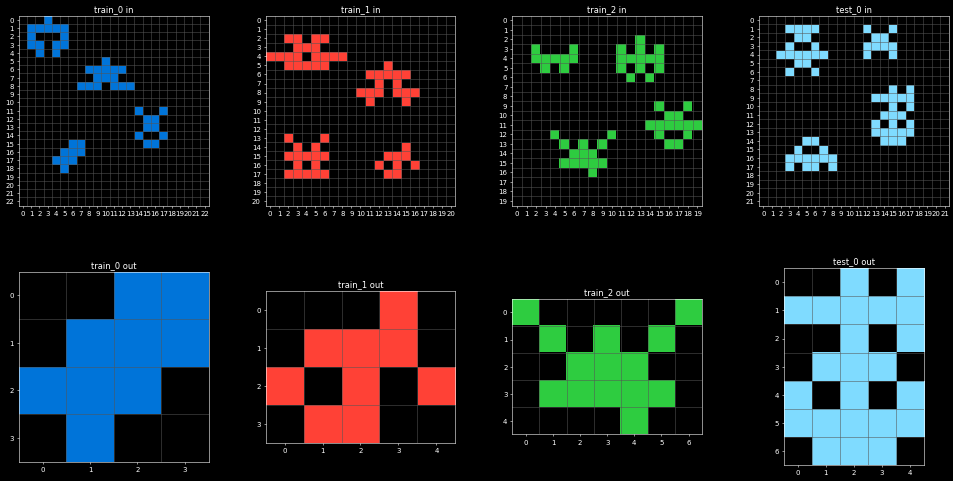

In [470]:
s.plot()

In [861]:
pd.DataFrame(data, columns=['method', 'task', 'rank'])

,method,task,rank
0,MetricInfo,0,NaN
1,absolute_import,0,NaN
2,braycurtis,0,3.0
3,callable,0,NaN
4,canberra,0,2.0
...,...,...,...
171,string_types,3,NaN
172,warnings,3,NaN
173,wminkowski,3,NaN
174,xrange,3,NaN


In [978]:
(1 - compute_freq_matrix(s.nbrs[0][0], ).mean(0)) * .01

array([0.00997927, 0.00998724, 0.00995653, 0.00997715], dtype=float32)

In [980]:
idx

3

In [1021]:
1-distance.cosine([.1,.1, 0,.9], [0,.2,0,.8])

0.9850045059202538

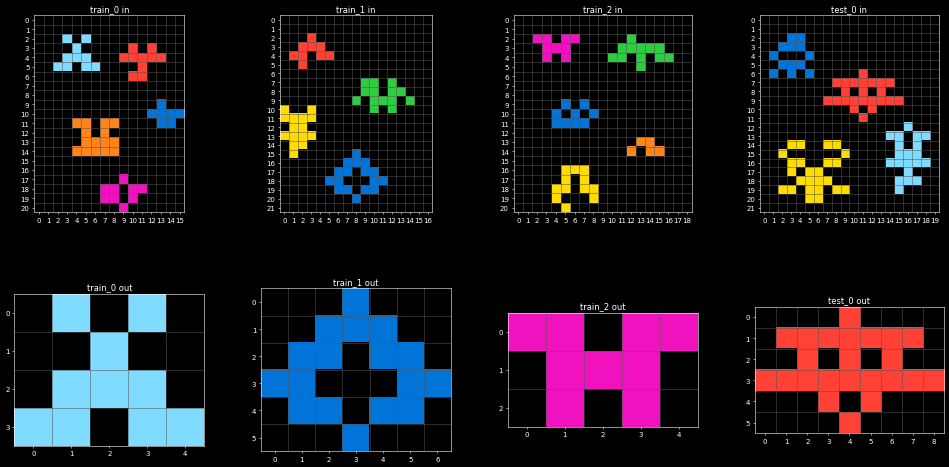

In [1108]:
s = Solver('d56f2372')
s.plot()

0


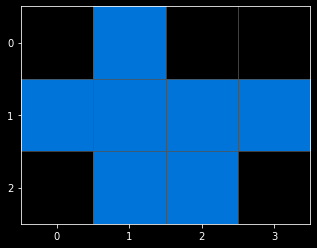

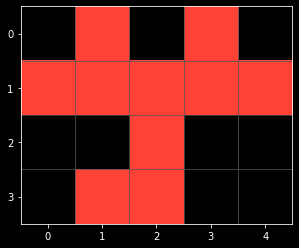

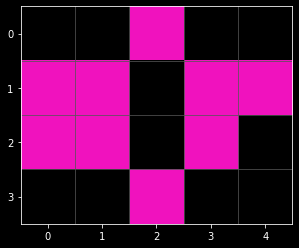

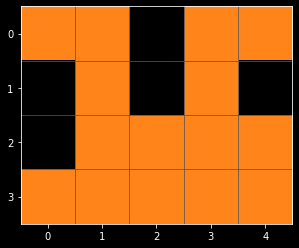

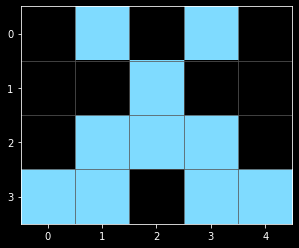

1


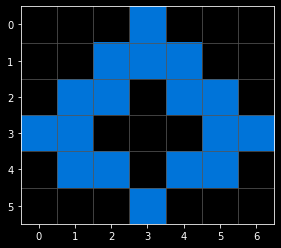

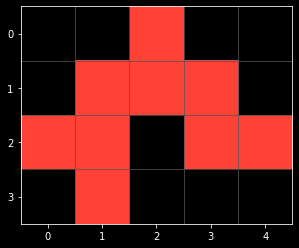

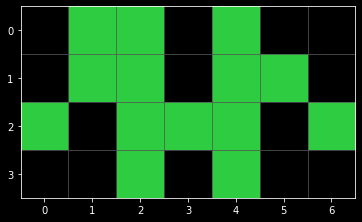

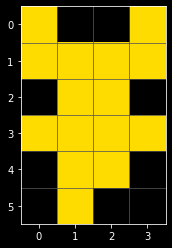

2


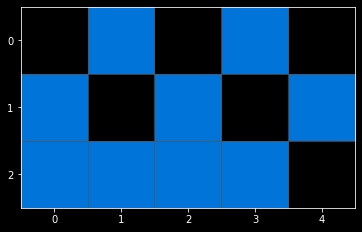

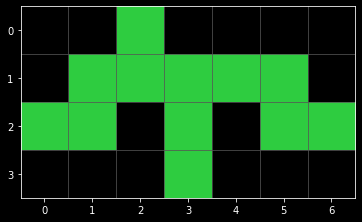

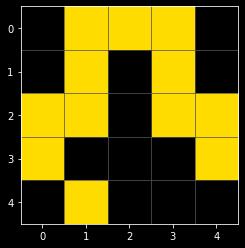

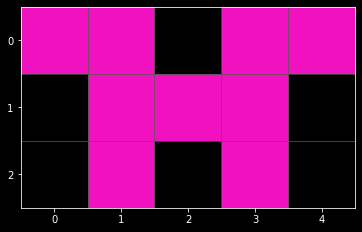

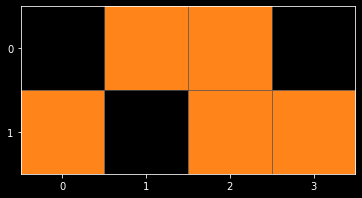

3


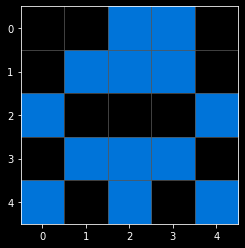

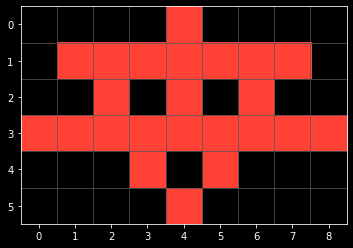

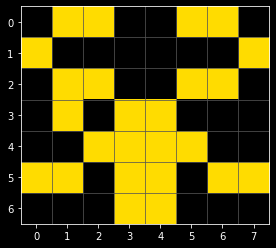

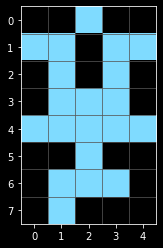

In [1110]:
for i in range(4):
    print(i)
    objs = s.nbrs[i][0]
    for o in objs:
        o.plot(); plt.show()

In [1169]:
def compute_distance(u, v, methods=None, fns=None):
    if methods is None:
        methods = ['euclidean', 'hamming', 'cosine']
    if fns is None:
        fns = [identity, rot90, flip_x, transpose]
    
    if isinstance(u, Object):
        u = u.data
    if isinstance(v, Object):
        v = v.data
    u = u.astype(bool).astype(np.float32)
    v = v.astype(bool).astype(np.float32)
    sims = []
    for method in methods:
        x_sim = compute_sim_matrix([u, v], method, fns=fns)[0,1]
        sims.append(x_sim)
    return sims

In [1171]:
objs[1]

<Object: shape=(6, 9), dtype=uint8, numpy=
array([[0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 2, 2, 2, 2, 2, 2, 2, 0],
       [0, 0, 2, 0, 2, 0, 2, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 2, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0]], dtype=uint8)>

In [1168]:
compute_distance(objs[0].data, objs[1].data)

[2.184562, 0.325, 0.5695764]

In [1159]:
np.mean(compute_distance(objs[0].data, objs[1].data), axis=0)

array([0.6813759 , 0.75685453], dtype=float32)

In [1145]:
df_rank = pd.DataFrame()
target = 3
bad = []
# for idx, target in [(0,3), (1, 3), (2, 3), (3, 2)]:
for idx, target in [(0,4), (1,1), (2,3), (3,1)]:
    objs = s.nbrs[idx][0]
    freq_sim = compute_freq_matrix(objs, normalize=True ).mean(0)
#     for method in [x for x in dir(distance) if not x.startswith('_')]:
    for method in ['euclidean', 'hamming', 'cosine']:
        data = []
#         try:
        v = compute_sim_matrix(objs, method,  fns=[identity, rot90, flip_x, transpose]).mean(0)
        rank = v.argsort().argsort()[target]
#         v = 1 - v
#             if method == 'cosine':
#                 v = 1 - v
        combo_rank = ((freq_sim + v) / 2).argsort().argsort()[target]
        data = [method, idx, rank, combo_rank] + v.tolist()
#         except:
#             bad.append(method)
            
#             data.append([method, idx, np.nan, np.nan] + [np.nan] * 4)
    #     if rank == 0 or rank == 3:
    #         print(method)
    #         print(v)
    #         print(f'rank: {rank}')
    #         print()
        extras = list(range(5))
        n_miss = len(extras) - len(v)
        for i in range(n_miss):
            data.append(np.nan)
        df_rank = pd.concat((df_rank, pd.DataFrame([data], columns=['method', 'task', 'rank', 'combo_rank'] + extras)))
#     break

/Users/tanner/.pyenv/versions/3.6.5/envs/kaggle-arc-3.6.5/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/tanner/.pyenv/versions/3.6.5/envs/kaggle-arc-3.6.5/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in true_divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [1148]:
df_rank.groupby('task')[[0,1,2,3, 4]].mean()

,0,1,2,3,4
task,,,,,
0,0.635442,0.683018,0.722369,0.725076,0.710638
1,0.764328,0.716275,0.745531,0.740899,NaN
2,0.660913,0.753776,0.781553,0.676766,0.721324
3,0.896263,0.924510,1.032155,0.950320,NaN


In [1147]:
df_rank.groupby(['task', 'method'])[[0,1,2,3, 4]].mean()

0         1         2         3         4
task method                                                     
0    cosine     0.291788  0.357943  0.430403  0.358741  0.436966
     euclidean  1.274954  1.378611  1.407538  1.467875  1.374115
     hamming    0.339583  0.312500  0.329167  0.348611  0.320833
1    cosine     0.421228  0.429286  0.416897  0.390427       NaN
     euclidean  1.615896  1.442196  1.558630  1.530620       NaN
     hamming    0.255859  0.277344  0.261068  0.301649       NaN
2    cosine     0.431112  0.497301  0.515193  0.451457  0.543188
     euclidean  1.286003  1.505695  1.535718  1.309742  1.302382
     hamming    0.265625  0.258333  0.293750  0.269097  0.318403
3    cosine     0.491470  0.467636  0.522514  0.479653       NaN
     euclidean  1.891589  2.039540  2.239578  2.054249       NaN
     hamming    0.305729  0.266354  0.334375  0.317057       NaN

In [1141]:
df_rank.loc[df_rank['method'] == 'euclidean']

,method,task,rank,combo_rank,0,1,2,3,4
0,euclidean,0,1,2,-0.274954,-0.378611,-0.407538,-0.467875,-0.374115
0,euclidean,1,0,2,-0.615896,-0.442196,-0.558630,-0.530620,NaN
0,euclidean,2,2,2,-0.286003,-0.505695,-0.535718,-0.309742,-0.302382
0,euclidean,3,1,1,-0.891589,-1.039540,-1.239578,-1.054249,NaN


In [1139]:
s.task_id

'd56f2372'

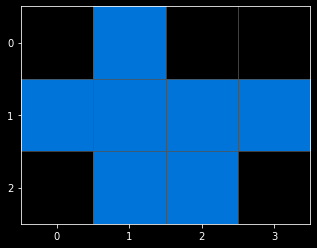

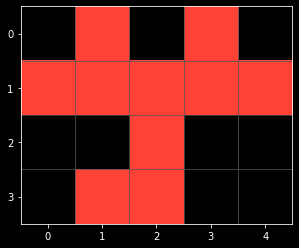

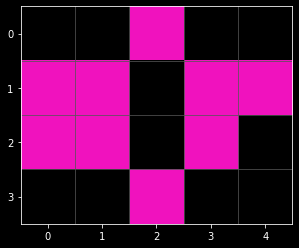

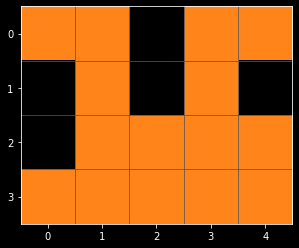

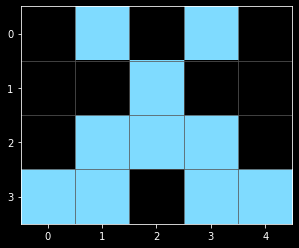

In [1138]:
for o in s.nbrs[0][0]:
    o.plot(); plt.show()

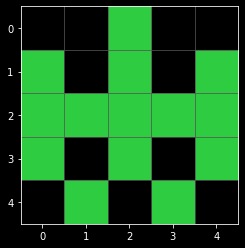

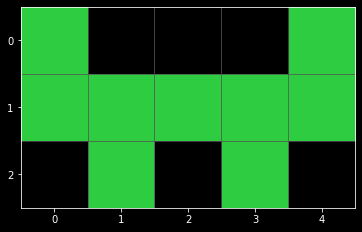

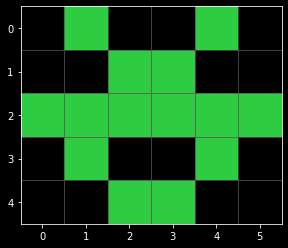

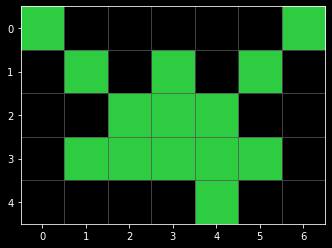

In [1105]:
idx = 2
objs = s.nbrs[idx][0]
for o in objs:
    o.plot(); plt.show()

In [1032]:
# def compute_sim_matrix(objs, method='euclidean', kernel_shape=(3,3), strides=None, fns=None):
#     d = getattr(distance, method)
#     fns = [identity] if fns is None else fns
#     num_objs = len(objs)
#     sim_matrices = []
    
#     for f in fns:
#         x_sim = np.zeros((num_objs, num_objs), dtype=np.float32)
#         aug_objs = [f(obj.data) for obj in objs]
#         max_dims = np.max([o.shape for o in aug_objs], axis=0)
#         h_max = int(max_dims[0])
#         w_max = int(max_dims[1])
#         h_max = h_max if h_max % 2 == 0 else h_max + 1
#         w_max = w_max if w_max % 2 == 0 else w_max + 1
        
#         kernel_shape = (h_max, w_max)

#         objs_padded = []
#         for obj in aug_objs:
#             h, w = obj.shape
#             hp, wp = h_max - h, w_max - w
#             hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
#             wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
#             objs_padded.append(pad(obj.astype(bool).astype(np.float32), hp, wp))

#         for i in range(num_objs):
#             for j in range(num_objs):
#                 x_sim[i, j] = np.mean(sim_conv(f(objs_padded[i]), f(objs_padded[j]), method=method, kernel_shape=kernel_shape, strides=strides))
# #             x_sim[i, j] = d(objs_padded[i].ravel(), objs_padded[j].ravel())
#         sim_matrices.append(x_sim)
# #     sim_matrix = np.mean()
    
#     return np.mean(sim_matrices, axis=0)

In [1149]:
def compute_sim_matrix(objs, method='euclidean', kernel_shape=None, strides=None, fns=None):
    d = getattr(distance, method)
    fns = [identity] if fns is None else fns
    num_objs = len(objs)
    sim_matrices = []
    objs = [obj.astype(bool).astype(np.float32) for obj in objs]
    
    x_sim = np.zeros((num_objs, num_objs), dtype=np.float32)
    for i in range(num_objs):
        for j in range(num_objs):
            scores = []
            for f in fns:
                scores.append(np.mean(sim_conv(objs[i], f(objs[j]), method=method, kernel_shape=kernel_shape, strides=strides)))
            x_sim[i, j] = np.mean(scores)
#             x_sim[i, j] = d(objs_padded[i].ravel(), objs_padded[j].ravel())
#     sim_matrices.append(x_sim)
    
    return x_sim # np.mean(sim_matrices, axis=0)

In [1082]:
compute_sim_matrix(objs, 'cosine',  fns=[identity, rot90, flip_x, transpose]).mean(0)#.argsort().argsort()[2]

array([0.43278605, 0.5062247 , 0.44602764, 0.42331246], dtype=float32)

In [1066]:
def sim_conv(x, y, kernel_shape=(2,2), strides=None, method='cosine'):
    d = getattr(distance, method)
    h_max, w_max = np.asarray(np.max([x.shape, y.shape], axis=0), int)
    h_max = h_max if h_max % 2 == 0 else h_max + 1
    w_max = w_max if w_max % 2 == 0 else w_max + 1
        
    hp, wp = h_max - x.shape[0], w_max - x.shape[1]
    hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
    wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
    x = pad(x, hp, wp)
    
    hp, wp = h_max - y.shape[0], w_max - y.shape[1]
    hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
    wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
    y = pad(y, hp, wp)
    
    h, w = x.shape
    kh, kw = (h_max//2, w_max//2) if kernel_shape is None else kernel_shape
    if strides is None:
        sh, sw = kh, kw
    elif isinstance(strides, int):
        sh, sw = (strides, strides)
    else:
        sh, sw = strides
    strided_h = int(np.ceil((h - kh + 1) / sh))
    strided_w = int(np.ceil((w - kw + 1) / sw))
    
    sims = []
    for i in range(strided_h):
        for j in range(strided_w):
#             print(x[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)])
            v = d(x[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)].ravel(), 
                  y[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)].ravel())
#             print(v)
            sims.append(0. if np.isnan(v) else v)
#             sims.append(d(x[i:i+kh, j:j+kw].ravel(), y[i:i+kh, j:j+kw].ravel()))
    return sims

In [839]:
def compute_symbol_freq(x, symbols=None, normalize=False):
    symbols = range(NUM_SYMBOLS) if symbols is None else symbols
    x_symbols = np.ravel(x).tolist()
    x_freq = np.array([x_symbols.count(s) for s in symbols], dtype=np.float32)
    if normalize:
        return x_freq / sum(x_freq)
    else:
        return x_freq
    
    
def compute_freq_matrix(objs, method='cosine', symbols=None, normalize=False):
    d = getattr(distance, method)
    symbols = range(NUM_SYMBOLS) if symbols is None else symbols
    num_objs = len(objs)
    x_freq = np.zeros((num_objs, num_objs), dtype=np.float32)
    for i in range(num_objs):
        for j in range(num_objs):
            x_freq[i, j] = d(compute_symbol_freq(objs[i].data, symbols=symbols, normalize=normalize),
                             compute_symbol_freq(objs[j].data, symbols=symbols, normalize=normalize))
    return x_freq

In [ ]:
input_counts = [frequency(x, symbol) for x in self.inputs]

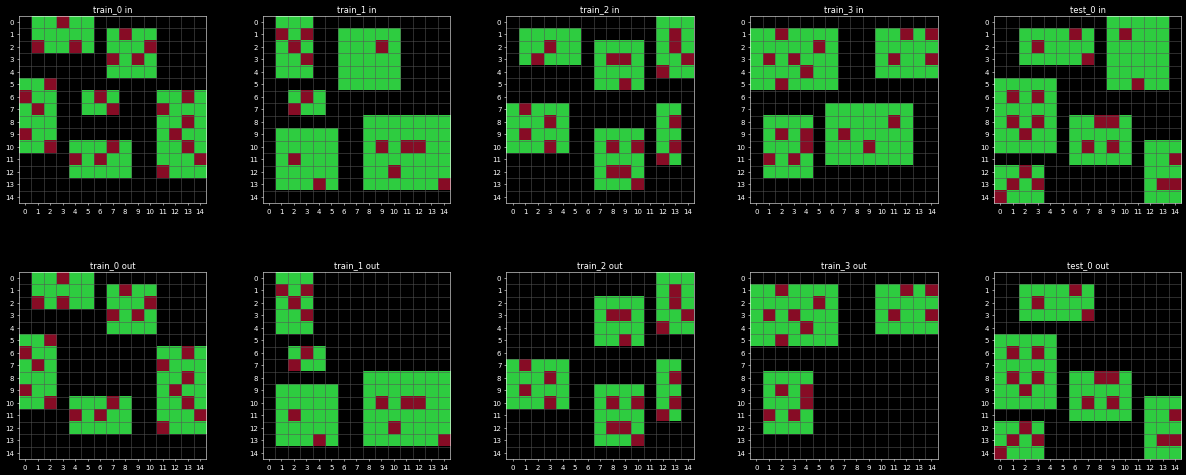

In [397]:
task_id = '54db823b'
task = Task(id_to_filepath[task_id])
objs = task.nbrs[0][0]
task.plot()

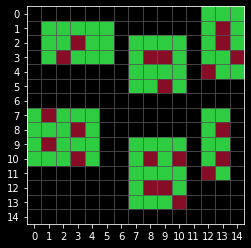

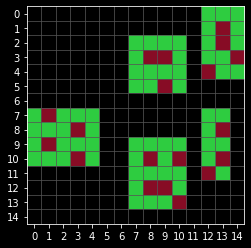

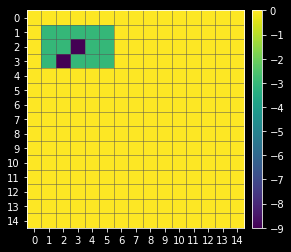

In [398]:
idx = 2
x = task.inputs[idx]
y = task.outputs[idx]
plot_grid(x); plt.show();
plot_grid(y); plt.show();

if x.shape == y.shape: 
    plot_gradient(y - x);

In [399]:

class Graph:
    """Graph base claas.
    """
    def __init__(self, graph=None, nodes=None, edges=None, **kwargs):
        self.graph = {}
        self._nodes = Nodes(nodes)
        self._edges = Edges(edges)
        self._adj = {}
        # attempt to load graph with data
        if graph is not None:
            print('unstable')
            self._nodes.update(graph.nodes)
            self._edges.update(graph.edges)
#             convert.to_networkx_graph(incoming_graph_data, create_using=self)
        self.graph.update(kwargs)

    @property
    def name(self):
        """Represents the name of the graph."""
        return self.graph.get('name', str(id(self)))
    
    @name.setter
    def name(self, s):
        self.graph['name'] = s
        
    @property
    def nodes(self):
        return self._nodes
    
    @property
    def edges(self):
        return self._edges
    
    @property
    def order(self):
        """Returns the number of nodes in the graph."""
        return len(self._nodes)
    
    @property
    def adj(self):
        """Returns an iterator over each node and their neighbors."""
        return {**{u.name: {} for u in self.nodes}, **self._edges.adj}
    
    @property
    def degree(self):
        """Returns the number of edges that flow through each node."""
        d = {u.name: 0 for u in self._nodes}
        for u, nbrs in self.adjacency():
            d[u] = sum([u.get('weight') or 1 for u in nbrs.values()])
        return d
    
    def __str__(self):
        """Returns the name of the graph."""
        return f'{self.__class__.__name__}({self.name})'

    def __iter__(self):
        """Returns an iterator over all nodes in the graph."""
        return iter(self._nodes)

    def __contains__(self, u):
        """Returns True if `node` is a node in the graph, False otherwise."""
        try:
            return u in self._nodes
        except TypeError:
            return False

    def __len__(self):
        """Returns the number of nodes in the graph."""
        return len(self._nodes)

    def __getitem__(self, u):
        """Returns a dict of neighbors for a node."""
        return self._edges[u]
        try:
            return self._edges.get(u, self._nodes[u])
        except KeyError:
            raise KeyError(f'Node {u} is not in the graph.')
            
    def __repr__(self):
        format_str = f'{self.__class__.__name__}(\n'
        format_str += f'    {self.nodes}\n'
        e_str = '\n    '.join(str(self._edges).split('\n'))
        format_str += f'    {e_str}\n'
        format_str += f'    Order({self.order})\n'
        format_str += ')'
        return format_str
    
    def _iter(self, nodes):
        for node in nodes:
            if node in self._adj:
                yield node

    def add_node(self, u, **kwargs):
        """Add a single node to graph attributes."""
        self._nodes.add_node(u, **kwargs)

    def add_nodes(self, nodes):
        """Add multiple nodes."""
        self._nodes.update(nodes)

    def remove_node(self, u):
        """Remove a ndoe from the graph."""
        self._nodes.remove(u)

    def remove_nodes(self, nodes):
        """Remove multiple nodes."""
        for u in nodes:
            self.remove_node(u)
    
    def num_nodes(self):
        """Returns the number of nodes in the graph."""
        return len(self._nodes)

    def has_node(self, u):
        """Returns True if the graph contains the node n."""
        try:
            return u in self._nodes
        except TypeError:
            return False

    def add_edge(self, u, v, directed=None, **kwargs):
        """Add an edge between `node_a` and `node_b`."""
        u = u if isinstance(u, Node) else Node(u)
        v = v if isinstance(v, Node) else Node(v)
        
        if u not in self._nodes:
            self.add_node(u)
        else:
            u = self._nodes[u]
        if v not in self._nodes:
            self.add_node(v)
        else:
            v = self._nodes[v]
        self._edges.add_edge(u, v, directed=directed, **kwargs)

    def add_edges(self, edges, **kwargs):
        """Add a container of edges."""
        self._edges.update(edges)

    def remove_edge(self, e):
        """Remove the edge between `node_a` and `node_b`."""
        self._edges.remove(e)

    def remove_edges(self, edges):
        """Remove a container of edges from the graph."""
        for e in edges:
            self.remove_edge(e)

    def update(self, edges=None, nodes=None):
        """Update the graph using nodes/edges/graphs as input."""
        if edges is not None:
            if nodes is not None:
                self.add_nodes(nodes)
                self.add_edges(edges)
            else:
                graph_nodes = getattr(edges, 'nodes')
                graph_edges = getattr(edges, 'edges')
                if graph_nodes is not None and graph_edges is not None:
                    self.add_edges(edges)
                else:  
                    print('check this')
                    self.add_nodes(graph_nodes.data())
                    self.add_edges(graph_edges.data())
                    self.graph.update(edges.graph)
        elif nodes is not None:
            self.add_nodes(nodes)

    def has_edge(self, u, v):
        """Returns True if the edge `node_a`-`node_b` is in the graph."""
        try:
            return v in self._edges[u]
        except KeyError:
            return False

    def neighbors(self, u):
        """Returns an iterator over all neighbors of a node."""
        try:
            return iter(self._edges[u])
        except KeyError:
            raise KeyError(f"Node {u} is not in the graph.")

    def get_node(self, u, default=None):
        return self._nodes.get(u, default)
    
    def get_edge(self, u, v, default=None):
        """Equivalent to `G.get(node_a, {}).get(node_b, default)`."""
        try:
            return self._edges[u][v]
        except KeyError:
            return default

    def adjacency(self):
        return iter(self.adj.items())

    def get_degree(self, u):
        nbrs = self._edges.get(u, {})
        return sum([u.get('weight') or 1 for u in nbrs.values()])

    def clear(self):
        """Remove all nodes and edges from the graph."""
        self._nodes = Nodes()
        self._edges = Edges()
        self.graph.clear()

    def reset(self):
        """Remove all nodes and edges from the graph."""
        self.clear()
    
    def is_multigraph(self):
        """Returns True if graph is a multigraph, False otherwise."""
        return False

    def is_directed(self):
        """Returns True if graph is directed, False otherwise."""
        return False

    def size(self, weight=None):
        """Returns the number of edges or total of all edge weights."""
        size = sum([degree for _, degree in self.degree(weight=weight)])
        # only count an edge between two nodes once
        return size // 2 if weight is None else size / 2

    def num_edges(self, node_a=None, node_b=None):
        """Returns the number of edges between two nodes."""
        if node_a is None:
            return int(self.size())
        if node_b in self._adj[node_a]:
            return 1
        return 0

    def iternodes(self, nodes=None):
        """Returns an iterator over a contrainer of nodes."""
        if nodes is None:   
            return iter(self._adj)
        elif nodes in self: 
            return iter([nodes])
        else:               
            return self._iter(nodes)
    
    def numpy(self):
        return get_adj_matrix(self)
    
    def get_sinks(self):
        return Nodes([u for u in self._nodes if u.is_sink()])
    
    def get_sources(self):
        return Nodes([u for u in self._nodes if u.is_source()])
    
    def get_subgraph(self, nodes):
        V = Nodes()
        E = Edges()
        
        if not isinstance(nodes, (Nodes, list, tuple)):
            nodes = [nodes]

        for u in nodes:
            V.add_node(self.get_node(u).copy())
            nbrs = self.adj[u]

            for v_i, e in nbrs.items():
                V.add_node(self.get_node(v_i).copy())
                E.add_edge(*e.vertices, **e)
                v_nbrs = self.adj[v_i]
                # i need to add a recursion here incase of nested node edges
                for v_j, e in v_nbrs.items():
                    V.add_node(self.get_node(v_j).copy())
                    E.add_edge(*e.vertices, **e)
#                     v_j_nbrs = self.adj[v_j]

        return Graph(nodes=V, edges=E)

In [400]:
class Solver(Task):
    
    def __init__(self, task_id):
        self.task_id = task_id
        self.filepath = id_to_filepath[self.task_id]
        super(Solver, self).__init__(self.filepath)
        
    def fit(self, ):
        pass
    
    def predict(self):
        pass

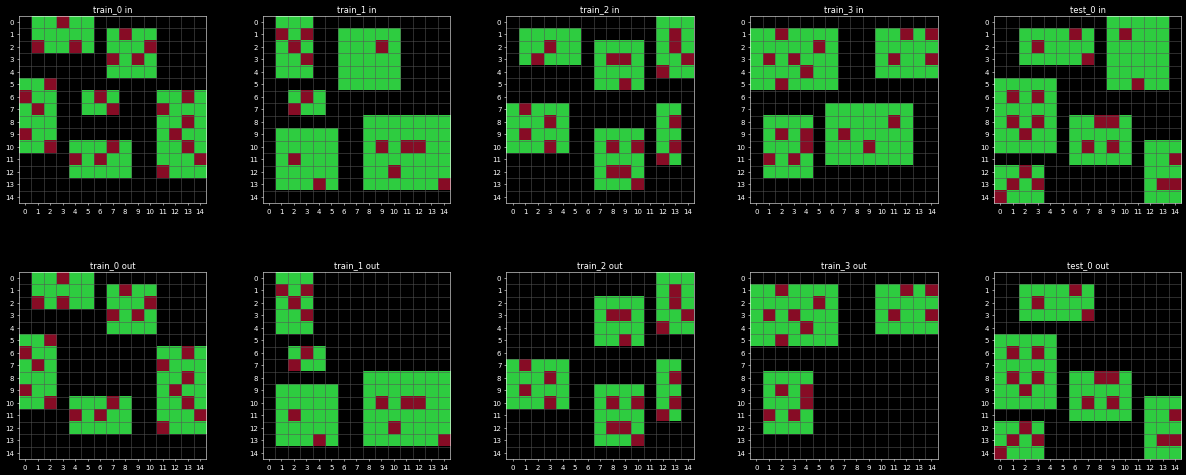

In [401]:
s = Solver(task_id)
s.plot()

In [378]:
objs_input = task.nbrs[0][0]
objs_output = task.nbrs[0][1]

In [404]:
get_objects(o)

[<Object: shape=(1, 1), dtype=uint8, numpy=
 array([[9]], dtype=uint8)>,
 <Object: shape=(1, 1), dtype=uint8, numpy=
 array([[9]], dtype=uint8)>,
 <Object: shape=(3, 5), dtype=uint8, numpy=
 array([[3, 3, 3, 0, 3],
        [0, 3, 0, 3, 3],
        [3, 3, 3, 3, 3]], dtype=uint8)>]

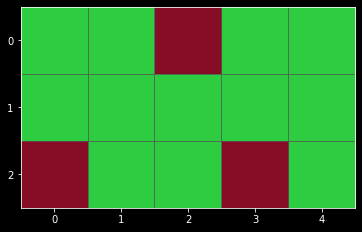

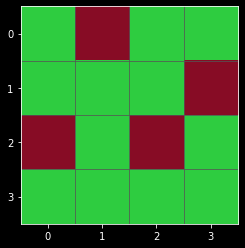

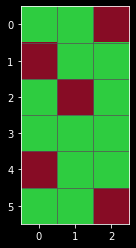

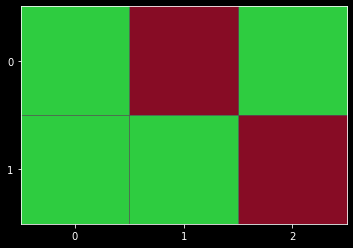

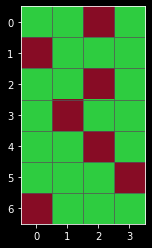

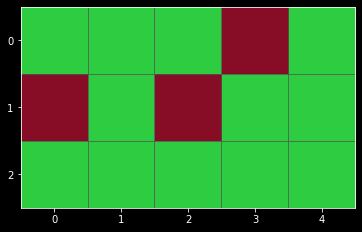

In [402]:
for o in task.symbolic_objects[0][0]:
    o.plot(); plt.show()

In [408]:
def build_local_graph(objs):
    graph = Graph()

    idx_to_obj = {i: obj for i, obj in enumerate(objs)}
    obj_to_idx = {v: k for k,v in idx_to_obj.items()}

    for i, obj in enumerate(objs):
        graph.add_node(Node(i, obj))
        for child_u in obj.children:
            # add a directed edge from the parent to child
            graph.add_edge(obj_to_idx[obj], obj_to_idx[child_u], directed=True)
            # add an undirected edge between each child
            # this will need to change to allow recusion
            for child_v in obj.children:
                if child_u is not child_v:
                    graph.add_edge(obj_to_idx[child_u], obj_to_idx[child_v])
                    
    return graph

In [ ]:
def build_global_graph(objs):
    graph = Graph()

    idx_to_obj = {i: obj for i, obj in enumerate(objs)}
    obj_to_idx = {v: k for k,v in idx_to_obj.items()}

    for i, obj in enumerate(objs):
        graph.add_node(Node(i, obj))
        for child_u in obj.children:
            # add a directed edge from the parent to child
            graph.add_edge(obj_to_idx[obj], obj_to_idx[child_u], directed=True)
            # add an undirected edge between each child
            # this will need to change to allow recusion
            for child_v in obj.children:
                if child_u is not child_v:
                    graph.add_edge(obj_to_idx[child_u], obj_to_idx[child_v])
                    
    return graph

In [410]:
objs = task.symbolic_objects[0][0]

In [412]:
obj_a = objs[0]
obj_b = objs[1]
obj_c = objs[2]
obj_d = objs[3]

In [ ]:
obj_a.

In [413]:
obj_a

<Object: shape=(3, 5), dtype=uint8, numpy=
array([[3, 3, 9, 3, 3],
       [3, 3, 3, 3, 3],
       [9, 3, 3, 9, 3]], dtype=uint8)>

In [416]:
obj_b == obj_a

False

In [406]:
build_graph(task.symbolic_objects[0][0])

Graph(
    Nodes(0, 1, 2, 3, 4, 5)
    Edges()
    Order(6)
)

In [332]:
graph = Graph()

idx_to_obj = {i: obj for i, obj in enumerate(objs)}
obj_to_idx = {v: k for k,v in idx_to_obj.items()}

for i, obj in enumerate(objs):
    graph.add_node(Node(i, obj))
    
    for child_u in obj.children:
        # add a directed edge from the parent to child
        graph.add_edge(obj_to_idx[obj], obj_to_idx[child_u], directed=True)
        
        # add an undirected edge between each child
        for child_v in obj.children:
            if child_u is not child_v:
                graph.add_edge(obj_to_idx[child_u], obj_to_idx[child_v])

                
sub_graphs = []
for u in graph.get_sources():
    sub_graphs.append(graph.get_subgraph(u))

In [333]:
sub_graphs = []
for u in graph.get_sources():
    sub_graphs.append(graph.get_subgraph(u))

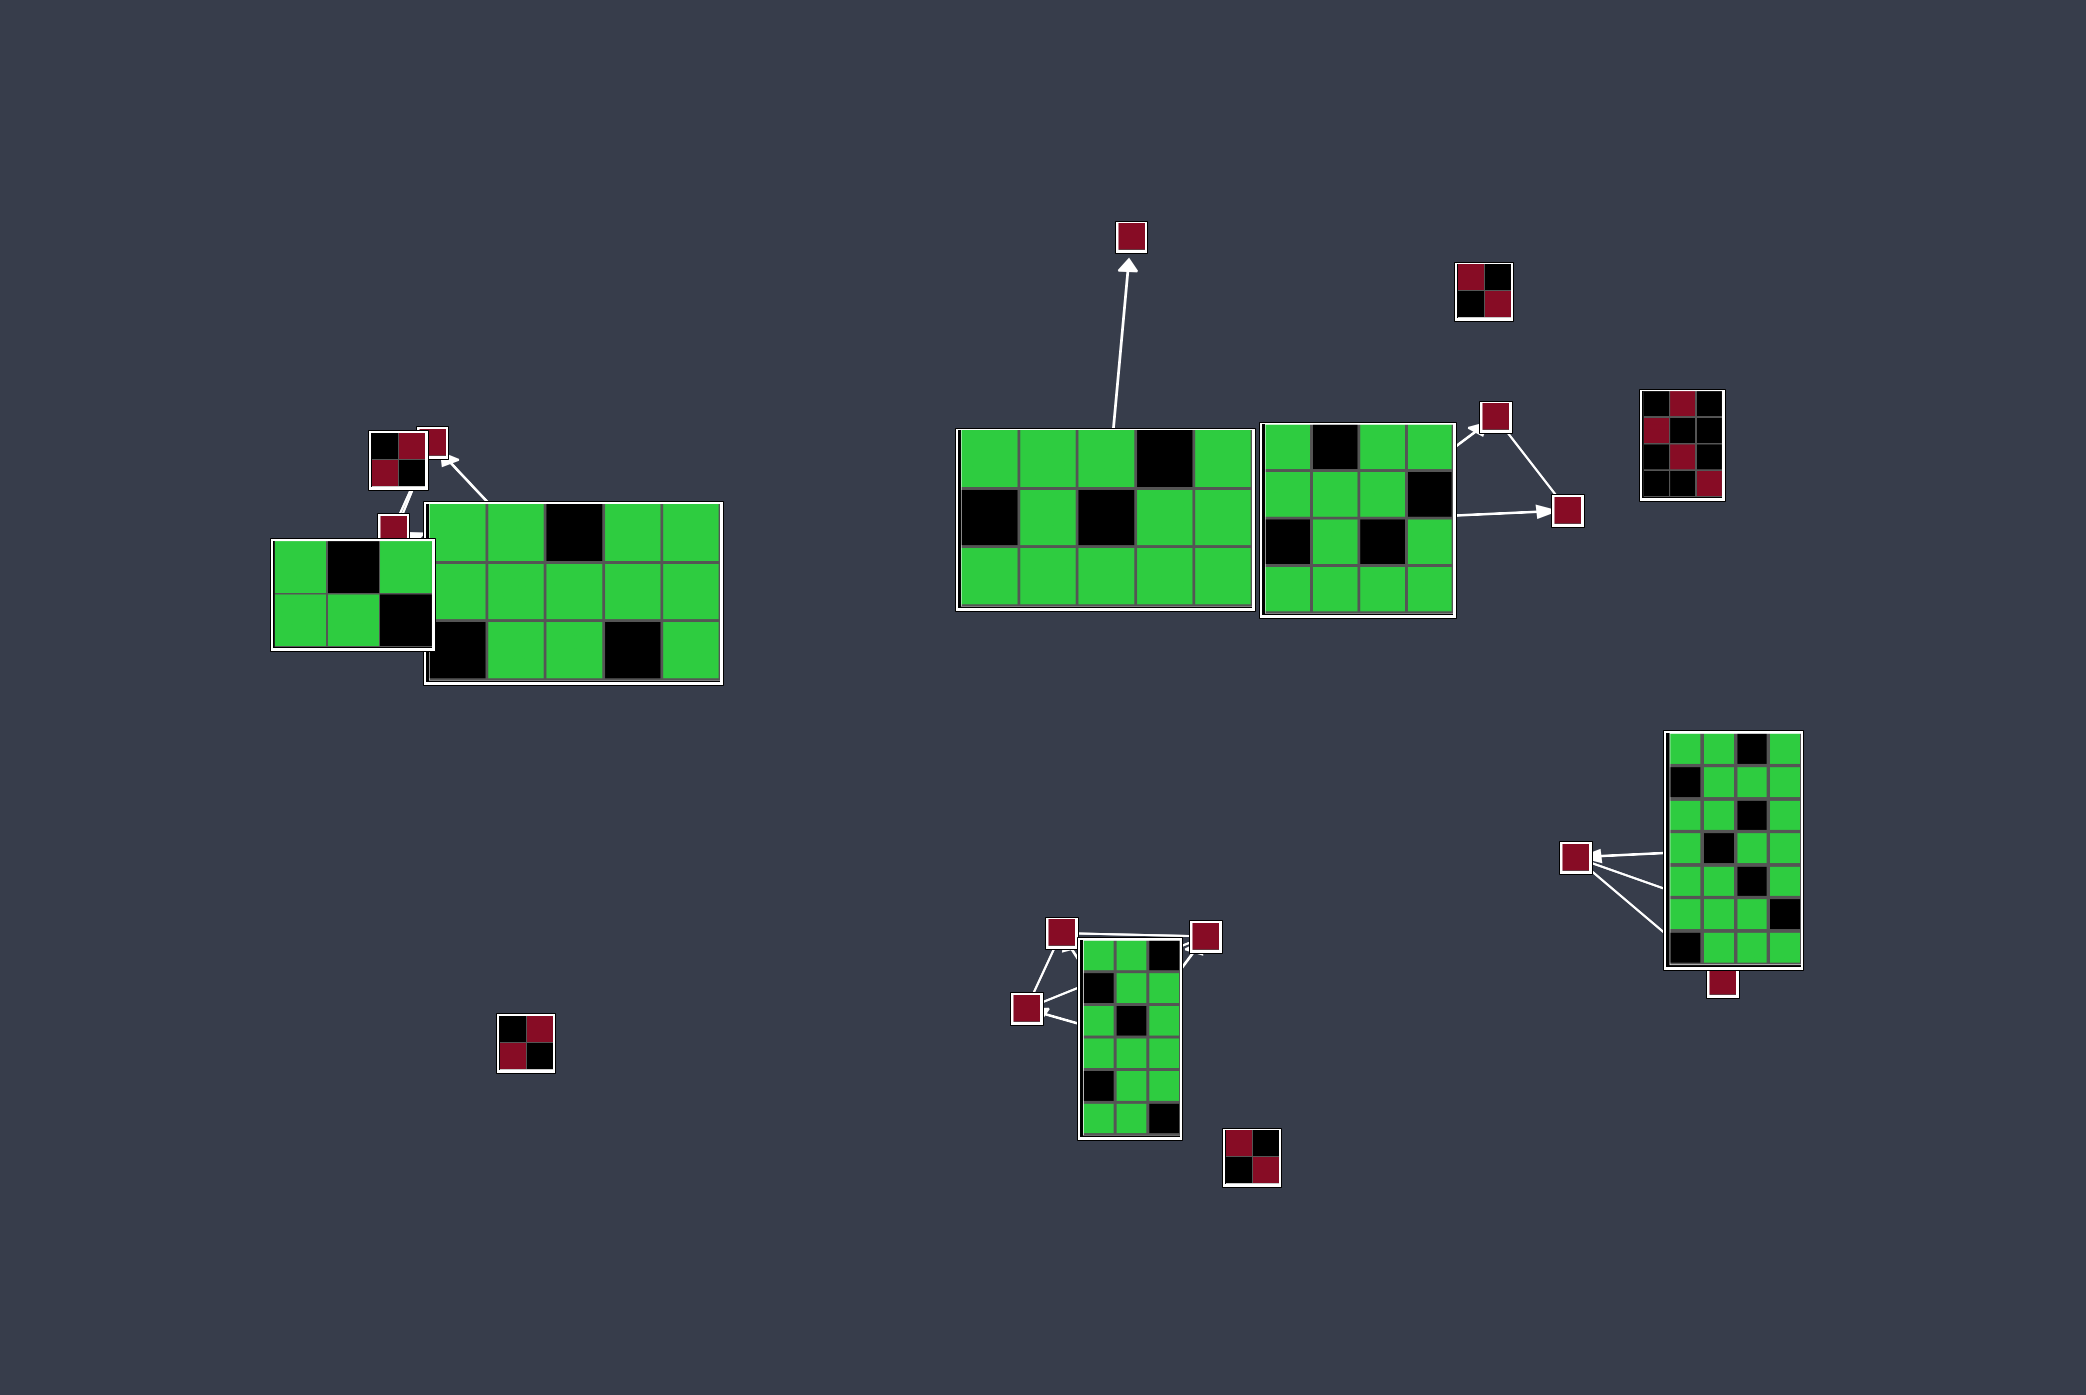

grpah: 5303814800


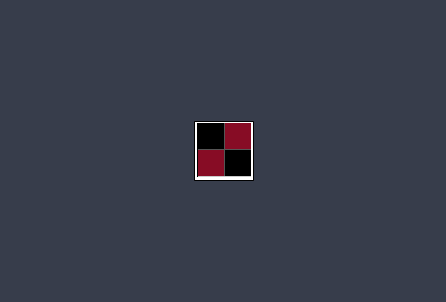

grpah: 4413538144


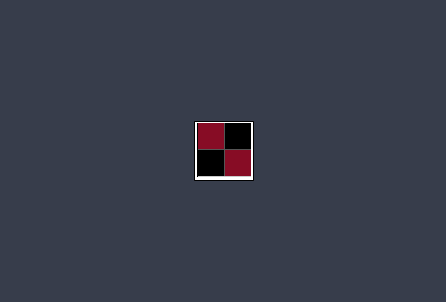

grpah: 5180172384


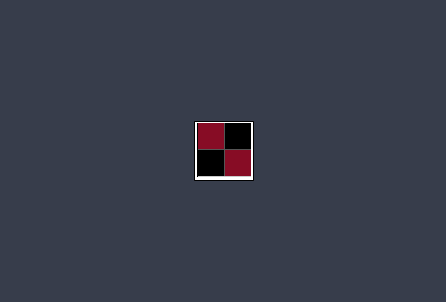

grpah: 5186713808


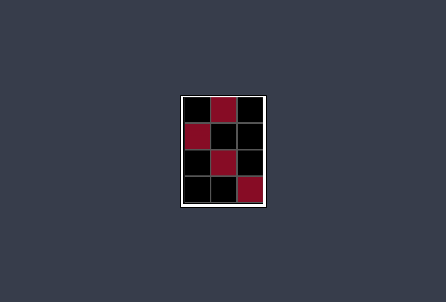

grpah: 5306334008


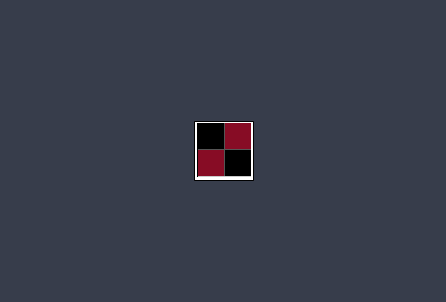

grpah: 5234855384


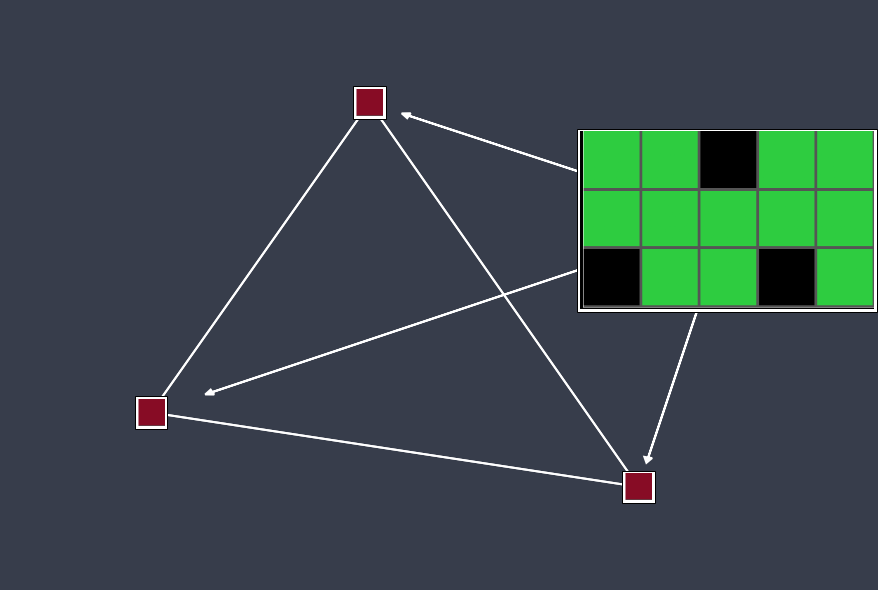

grpah: 5269889656


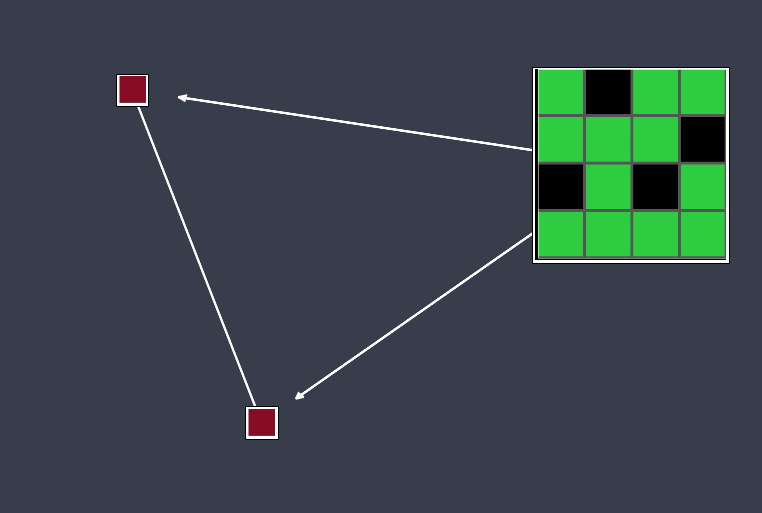

grpah: 5463469584


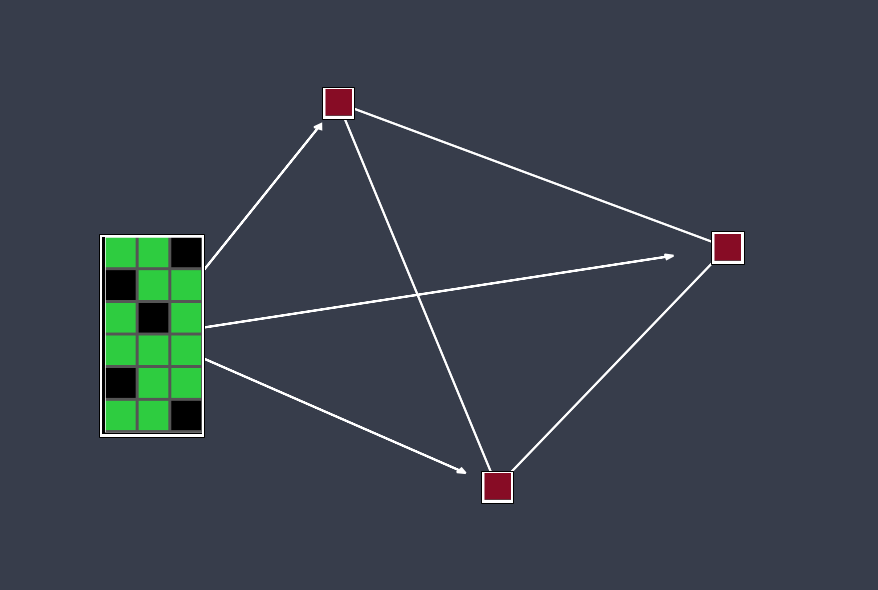

grpah: 5517379512


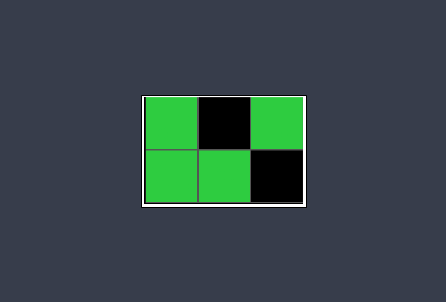

grpah: 5224225368


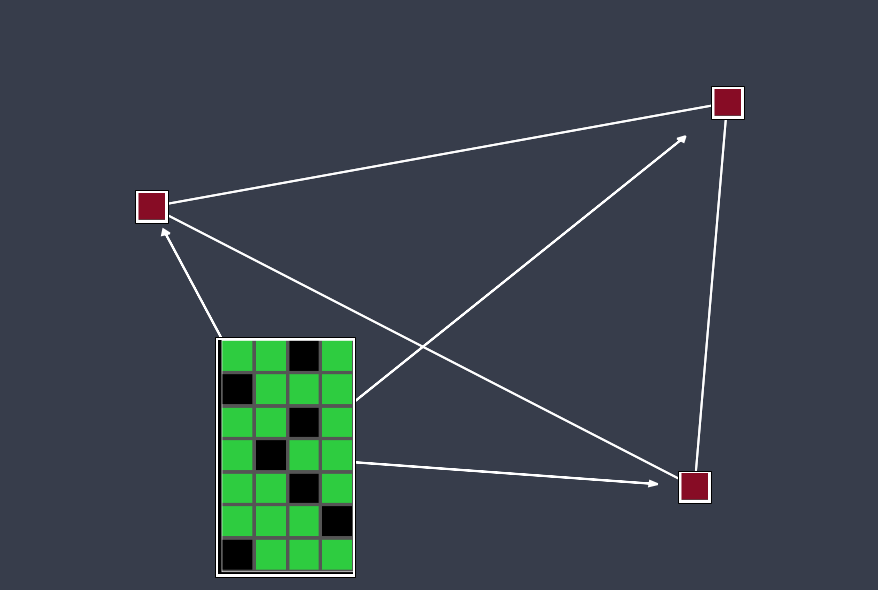

grpah: 5447422080


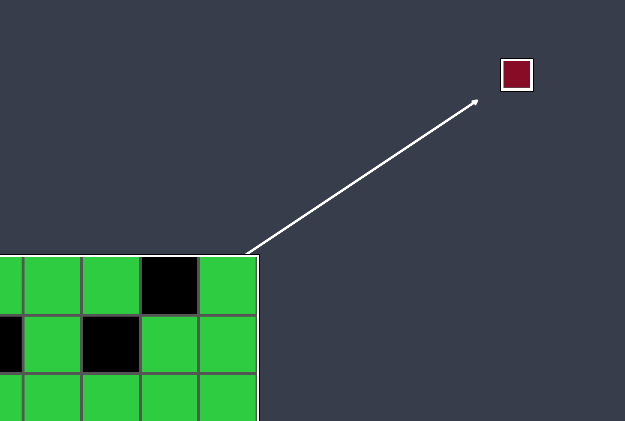

In [346]:
draw_graph(graph); plt.show();
for g in sub_graphs:
    print(f'grpah: {g.name}')
    draw_graph(g); plt.show();

In [16]:
from collections.abc import Mapping, Set

class Node(Mapping):
    """Node base class to represent a random variable in the graph."""
    
    def __init__(self, 
                 name,
                 datasource=None,
                 embedding=None,
                 weight=None,
                 **kwargs):
        self._name = name
        self.datasource = datasource
        self.embedding = embedding
        self.weight = weight
        self._indegree = 0
        self._outdegree = 0
        self.__dict__.update(kwargs)
        
        self._id = id(self.datasource)
        self._fname = None
        self._img = None
        self._format = 'png'
        
        self._set_img()
        
    @property
    def name(self):
        return self._name
    
    @name.setter
    def name(self, name):
        self._name = name
        self._save_obj()
        
    @property
    def params(self):
        return {
            k: v for k, v in self.__dict__.items() 
            if not k.startswith('_')
            and v is not None
        }
    
    @property
    def img(self):
        return self._img
    
    @img.setter
    def img(self, img):
        self._img = img
        
    @property
    def indegree(self):
        return self._indegree
    
    @indegree.setter
    def indegree(self, d):
        self._indegree = d
        if self._indegree < 0:
            raise ValueError('`indegree` cannot have a negative degree.')
        
    @property
    def outdegree(self):
        return self._outdegree
    
    @outdegree.setter
    def outdegree(self, d):
        self._outdegree = d
        if self._outdegree < 0:
            raise ValueError('`outdegree` cannot have a negative degree.')
            
    @property
    def data(self):
        return self.datasource
    
    @data.setter
    def data(self, datasource):
        self.datasource = datasource
        self._set_img()
    
    def __getitem__(self, k):
        return self.__dict__[k]
    
    def __len__(self):
        return len(self.params)
    
    def __iter__(self):
        return iter(self.params.keys())
    
    def __repr__(self):
        format_str = f'{self.__class__.__name__}(\n'
        format_str += f'    name: {self.name}\n'
        for k, v in self.params.items():
            s = (len(str(k))+2) * ' '
            v_str = f"\n\t{s}".join(repr(v).split('\n'))
            format_str += f'\t{k}: {v_str}\n'
        format_str += ')'
        return format_str
    
    def __str__(self):
        return f'{self.__class__.__name__}({self.name})'
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.name == other.name
        else:
            return self.name == other
    
    def __neq__(self, other):
        if isinstance(other, self.__class__):
            return self.name != other.name
        else:
            return self.name != other
        
    def __hash__(self):
        return hash(self.name)
    
    def _set_img(self):
        if self.is_obj():
            self._fname = os.path.join('/tmp', f'{self.name}.{self._format}')
            save_obj(self._fname, self.datasource, lw=4)
            self._img = plt.imread(self._fname, format=self._format)
            
    def get(self, k, default=None):
        try:
            return self.__dict__[k]
        except KeyError:
            return default
        
    def update(self, other=None, **kwargs):
        if other is not None:
            self.__dict__.update(other.params)
        self.__dict__.update(kwargs)
        self._set_img()
        
    def is_sink(self):
        return self._outdegree == 0
    
    def is_source(self):
        return self._indegree == 0
    
    def is_obj(self):
        return isinstance(self.datasource, Object)
    
    def copy(self):
        """Meta features like degree, will not be passed to the copy."""
        return Node(self._name, **{k: v for k, v in self.items()})

class Nodes(Set):
    """Node base class to represent a random variable in the graph."""

    def __init__(self, nodes=None):
        super(Nodes, self).__init__()
        self._nodes = {}
        self.update(nodes)
        
    def __len__(self):
        return len(self._nodes)

    def __iter__(self):
        return iter(self._nodes.values())

    def __getitem__(self, u):
        if isinstance(u, Node):
            return self._nodes[u.name]
        else:
            return self._nodes[u]
    
    def __contains__(self, u):
        return u in self._nodes

    def __str__(self):
        return self.__repr__()
    
    def __hash__(self):
        return id(self)
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            if len(self) == len(other):
                return len(set(self._nodes) & set(other._nodes)) == len(self)
            else:
                False
        else:
            False
            
    def __neq__(self, other):
        if isinstance(other, self.__class__):
            if len(self) == len(other):
                return len(set(self._nodes) & set(other._nodes)) != len(self)
            else:
                True
        else:
            True
            
    def __and__(self, other):
        return Nodes([u for u in set(other) if u in self])
    
    def __or__(self, other):
        return Nodes(list(self) + [u for u in set(other) if u not in self])
    
    def __sub__(self, other):
        return Nodes([u for u in self if u not in set(other)])

    def __repr__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += ', '.join([str(name) for name in self._nodes.keys()])
        format_str += ')'
        return format_str

    def add_node(self, u, **kwargs):
        if isinstance(u, Node):
            if u in self._nodes:
                self._nodes[u.name].update(u, **kwargs)
            else:
                self._nodes[u.name] = u
        else:
            if u in self._nodes:
                self._nodes[u].update(**kwargs)
            else:
                self._nodes[u] = Node(u, **kwargs)
    
    def update(self, nodes):
        if isinstance(nodes, (tuple, list)):
            for u in nodes:
                if not isinstance(u, Node):
                    raise ValueError(f'Expected node {u} to be of type `Node`, got {type(u)}')
                self.add_node(u)
        elif isinstance(nodes, dict):
            self._nodes.update(nodes)
        elif isinstance(nodes, self.__class__):
            self._nodes.update(nodes._nodes)
        elif isinstance(nodes, Node):
            self.add_node(nodes)
            
    def remove(self, u):
        try:
            if isinstance(u, Node):
                del self._nodes[u.name]
            else:
                del self._nodes[u]
        except KeyError: 
            raise KeyError(f"Node {u} is not in the set.")
            
    def intersection(self, other):
        return self.__and__(other)
    
    def union(self, other):
        return self.__or__(other)

    def difference(self, other):
        return self.__sub__(other)
    
    def get(self, u, default=None):
        try:
            return self[u]
        except KeyError:
            return default

In [17]:
def get_edge_data(e):
    if isinstance(e, Edge):
        return (*e.vertices, e.params)
    if len(e) == 2:
        return (*e, {})
    if len(e) == 3:
        return e
    else:
        raise ValueError('Expected an Edge or tuple/list of size 2 or 3, '
                        f'got {e}')

        
class Edge(Mapping):
    
    def __init__(self, 
                 u,
                 v,
                 directed=None,
                 distance=None,
                 embedding=None,
                 **kwargs):
        self._u = u if isinstance(u, Node) else Node(u)
        self._v = v if isinstance(u, Node) else Node(v)
        self.directed = directed
        self.distance = distance
        self.embedding = embedding
        self.__dict__.update(kwargs)
        
        self._vertices = (self._u, self._v)
        self._name = f'{self._u.name}-{self._v.name}'

    @property
    def params(self):
        return {
            k: v for k, v in self.__dict__.items() 
            if not k.startswith('_')
            and v is not None
        }
    
    @property
    def vertices(self):
        return self._vertices
    
    @property
    def head(self):
        return self._u
    
    @property
    def tail(self):
        return self._v
    
    def __getitem__(self, s):
        return self.__dict__[s]
    
    def __len__(self):
        return len(self.params)
    
    def __iter__(self):
        return iter(self.params.keys())
    
    def __repr__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += f'\n    vertices: ({self._u.name}, {self._v.name})\n'
        for k, v in self.params.items():
            s = (len(str(k))+2) * ' '
            v_str = f"\n\t{s}".join(repr(v).split('\n'))
            format_str += f'\t{k}: {v_str}\n'
        format_str += ')'
        return format_str
    
    def __str__(self):
        format_str = f'{self.__class__.__name__}({self._u.name}, {self._v.name}'
        if self.directed:
            format_str += f', directed={self.directed})'
        else:
            format_str += ')'
        return format_str
    
#     def get(self, s, default=None):
#         print('hi')
#         try:
#             self.__getitem__(s)
#             self[s]
#         except:
#             return default

    def update(self, other=None, **kwargs):
        if other is not None:
            self.__dict__.update(other.params)
        self.__dict__.update(kwargs)
        
        
class Edges(object):
    
    def __init__(self, edges=None):
        self._edges = []
        self._adj = {}
        self.update(edges)
        
    @property
    def adj(self):
        return self._adj
        
    def __len__(self):
        return len(self._edges)
        num_nbrs = (len(nbrs) + (n in nbrs) for n, nbrs in self._adj.items())
        return sum(num_nbrs) // 2

    def __iter__(self):
        for u, nbrs in self._adj.items():
            for v in nbrs:
                yield self[u, v]

    def __contains__(self, e):
        try:
            u, v, _ = get_edge_data(e)
            return v in self._adj[u]
        except KeyError:
            return False

    def __getitem__(self, e):
        if isinstance(e, (int, str)):
            return self._adj[e]
        elif isinstance(e, Node):
            return self._adj[e.name]
        u, v, _ = get_edge_data(e)
        return self._adj[u][v]
    
    def __str__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += ',\n      '.join([str(e) for e in self._edges])
        format_str += ')'
        return format_str

    def __repr__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += ',\n      '.join([str(e) for e in self._edges])
        format_str += ')'
        return format_str

    def update(self, edges):
        if isinstance(edges, (tuple, list)):
            for e in edges:
                u, v, attr = get_edge_data(e)
                self.add_edge(u, v, **attr)
        elif isinstance(edges, dict):
            print('unstable')
            self.update(edges)
        elif isinstance(edges, self.__class__):
            self.update(edges._edges)
        elif isinstance(edges, Edge):
            u, v, attr = get_edge_data(edges)
            self.add_edge(u, v, **attr)
            
    def add_edge(self, u, v, directed=None, **kwargs):
        u = u if isinstance(u, Node) else Node(u)
        v = v if isinstance(v, Node) else Node(v)
        u_name, v_name = u.name, v.name
        
        if u not in self._adj:
            self._adj[u_name] = {}
        edge = Edge(u_name, 
                    v_name, 
                    directed=directed,
                    **{**self._adj[u_name].get(v_name, {}), **kwargs})
        if (u_name, v_name) not in self:
            self._edges.append(edge)
            if directed:
                u.outdegree += 1
                v.indegree += 1
        self._adj[u_name][v_name] = edge
        
        if not directed:
            if v not in self._adj:
                self._adj[v_name] = {}
            self._adj[v_name][u_name] = edge
            
    def remove(self, e):
        try:
#             if isinstance(e, (int, str)):
#                 del self._adj[e]
#             elif isinstance(e, Node):
#                 del self._adj[e.name]
#             else:
#             is_directed = e.get('directed')
            u, v, _ = get_edge_data(e)
            del self._adj[u][v]
            if u != v:
                del self._adj[v][u]
        except KeyError: 
            raise KeyError(f"Node {u} is not in the set.")
        
        u.outdegree -= 1
        v.indegree -= 1
            
    def get(self, u, default=None):
        try:
            return self[u]
        except:
            return default
        


In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow
from matplotlib.patches import Rectangle as Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

from matplotlib.collections import PathCollection, LineCollection

plt.style.use('dark_background')

In [353]:
def draw_graph(graph, 
               node_to_pos=None,
               ax=None,
               method='fruchterman',
               arrows=None,
               random_state=None,
               **kwargs):
    """Draw a graph G with Matplotlib.

    Parameters
    ----------
    G : graph
       A networkx graph
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    ax : Matplotlib Axes object, optional
       Draw the graph in specified Matplotlib axes.
    kwds : optional keywords
       See networkx.draw_networkx() for a description of optional keywords.
    """
    if ax is None:
        cf = plt.gcf()
        if cf._axstack() is None:
            pass
            ax = cf.add_axes((0, 0, 1, 1))
        else:
            ax = cf.gca()
    else:
        cf = ax.get_figure()
    
    cf.set_facecolor('#373d4b')
    
    if node_to_pos is None:
        if method == 'spectral':
            node_to_pos = spectral_pos(graph)
        else:
            node_to_pos = fruchterman_reingold_pos(graph, 
                                                   random_state=random_state)
        
    node_params = kwargs.pop('node_params', {})
    edge_params = kwargs.pop('edge_params', {})

    node_collections = draw_nodes(graph, 
                                  node_to_pos, 
                                  random_state=random_state,
                                  **node_params)
    if len(graph.edges) > 0:
        edge_collections, arrow_collections = draw_edges(graph, 
                                                        node_to_pos,
                                                        arrows=arrows,
                                                        random_state=random_state,
                                                        **edge_params)
    
    scale = len([ar for ar in ax.artists if isinstance(ar, AnnotationBbox)])
    cf.set_figheight(cf.get_figheight() * np.sqrt(scale) )#* .9)
    cf.set_figwidth(cf.get_figwidth() * np.sqrt(scale) )#* .9)
    ax.margins(.25)

    plt.draw_if_interactive()
    ax.set_axis_off()

    
def draw_nodes(graph, 
               node_to_pos,
               nodes=None,
               ax=None,
               s=1,
               edgecolors='#000',
#                c='#1f78b4',
               marker='o',
               **kwargs):
    """Draw the nodes of a grahp.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.
    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.
    nodes : list, optional
       Draw only specified nodes (default G.nodes())
    
    Returns
    -------
    matplotlib.collections.PathCollection
        `PathCollection` of the nodes.
    """
    if ax is None:
        ax = plt.gca()

    if nodes is None:
        nodes = list(graph)
    if len(nodes) == 0:
        return PathCollection(None)
    
    try:
        xy = np.asarray([node_to_pos[u] for u in nodes])
    except KeyError as e:
        raise KeyError(f"Node {e} is not found in `node_to_pos`.")

    node_paths = ax.scatter(xy[:, 0],
                            xy[:, 1],
                            s=s,
                            edgecolors=edgecolors,
                            facecolors='w',
                            marker=marker)
    for i, u in enumerate(nodes):
        if u.is_obj():
            size = u.datasource.size
            imagebox = OffsetImage(u.img, zoom=max(np.log(size), .2) * .2)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, 
                                xy[i],
                                xybox=(.0, .0),
                                frameon=True,
                                xycoords='data',
                                pad=.3,
                                bboxprops={'lw': 1},
                                boxcoords="offset points",)
            ax.add_artist(ab)
    
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    node_paths.set_zorder(2)
    return node_paths


def draw_edges(graph, 
               node_to_pos,
               edges=None,
               nodes=None,
               ax=None,
               **kwargs):
    """Draws the edges of a graph.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.
    edges : collection of edge tuples
       Draw only specified edges(default=G.edges())
    """
    edge_collection = None
    arrow_collections = []
    
    ax = plt.gca() if ax is None else ax
    edges = graph.edges if edges is None else edges
    d_edges = [e for e in edges if e.get('directed')]
    ud_edges = [e for e in edges if not e.get('directed')]
    
    if len(edges) == 0:
        return LineCollection(None)
    
    nodes = graph.nodes if nodes is None else nodes 
    ud_pos = np.asarray([
        (node_to_pos[e.vertices[0]], node_to_pos[e.vertices[1]]) for e in ud_edges
    ])
    d_pos = np.asarray([
        (node_to_pos[e.vertices[0]], node_to_pos[e.vertices[1]]) for e in d_edges
    ])
    
    if len(ud_edges) > 0:
        line_params = {
            'color': kwargs.get('color', 'w'),
            'linewidths': kwargs.get('linewidth', 2.),
            'linestyle': kwargs.get('linestyle', 'solid'),
            'alpha': kwargs.get('alpha')
        }

        edge_collection = LineCollection(ud_pos,
                                         antialiaseds=(1,),
                                         transOffset=ax.transData,
                                         **line_params)

        edge_collection.set_cmap(kwargs.get('cmap'))
        edge_collection.set_clim(kwargs.get('clim'))

        edge_collection.set_zorder(1)  
        ax.add_collection(edge_collection)
    
#     scale = np.sqrt(1 - np.sqrt(1/len(nodes))) + .075
    if len(d_edges) > 0:
        head_pos = d_pos[:,1] 
        tail_pos = d_pos[:,0] 
        diff_pos = (head_pos - tail_pos) - .1 * (head_pos - tail_pos)
#         diff_pos = diff_pos - .1 * diff_pos
        

        
        arrow_params = {
            'ec': 'w',
            'fc': 'w',
            'lw': 2,
            'head_length': .025,
            'head_width': .025
        }
        
        for i in range(len(d_edges)):
            ar = FancyArrow(tail_pos[i,0], tail_pos[i,1], diff_pos[i,0], diff_pos[i,1], length_includes_head=True, width=.001, head_starts_at_zero=True, **arrow_params)
            ax.add_artist(ar)
            arrow_collections.append(ar)
    
    return edge_collection, arrow_collections


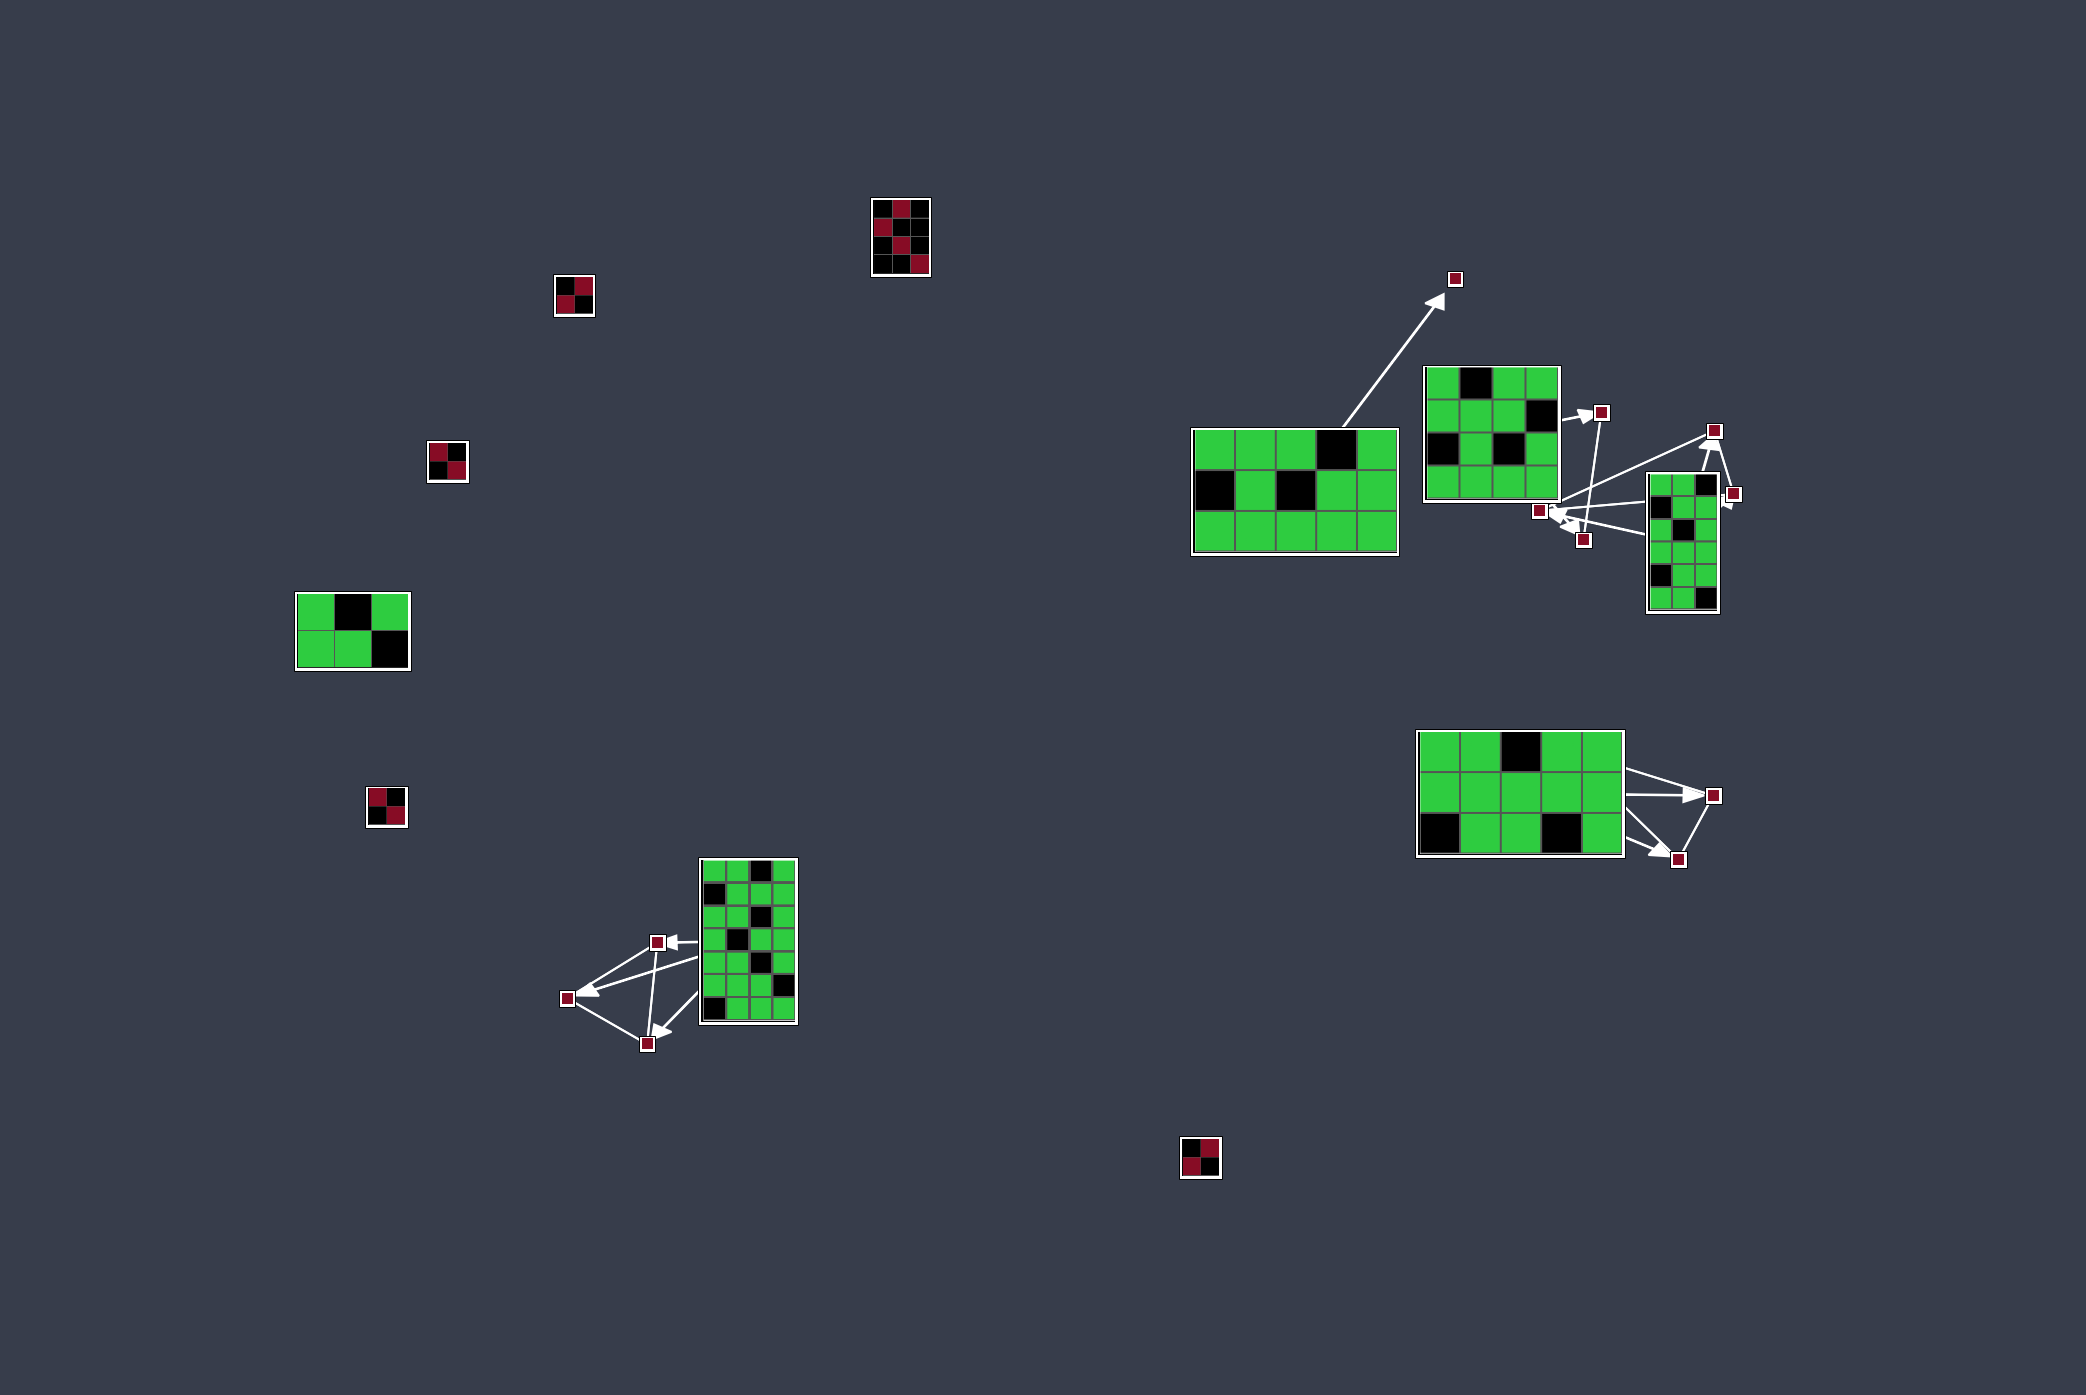

grpah: 5303814800


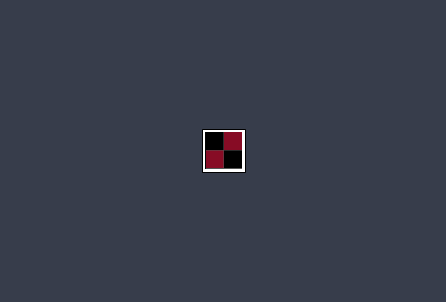

grpah: 4413538144


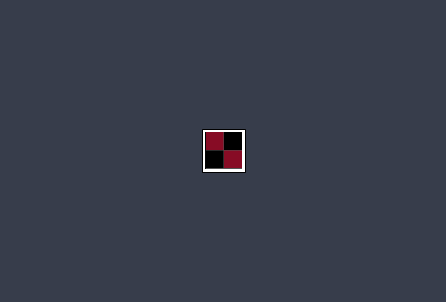

grpah: 5180172384


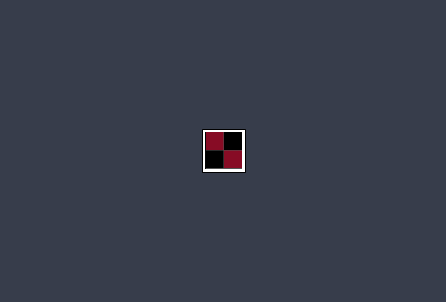

grpah: 5186713808


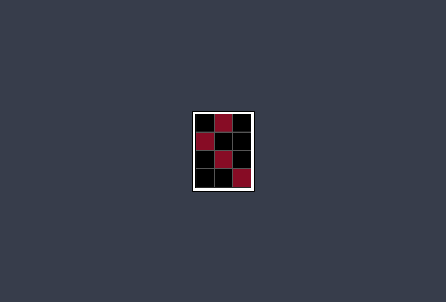

grpah: 5306334008


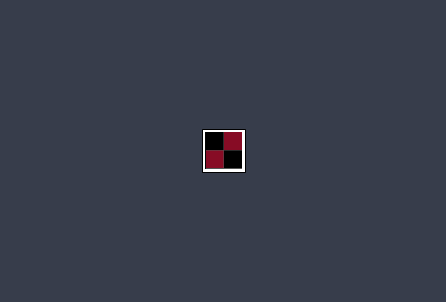

grpah: 5234855384


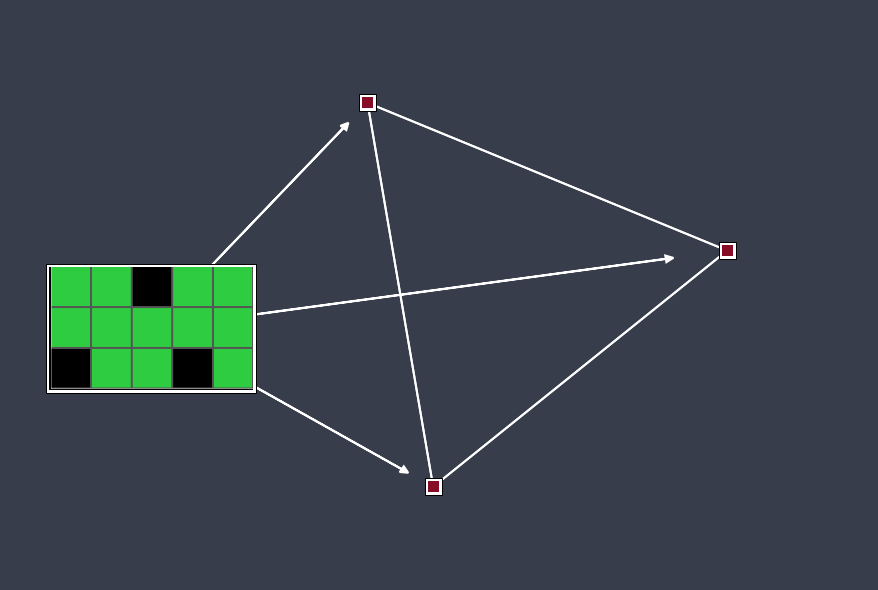

grpah: 5269889656


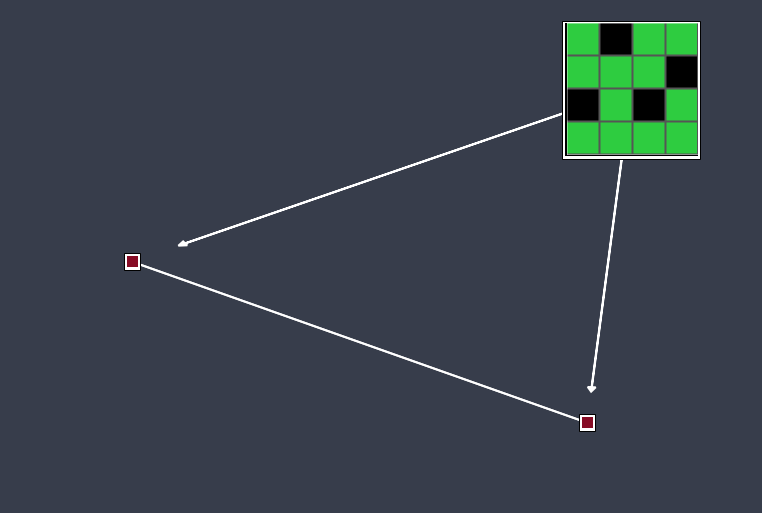

grpah: 5463469584


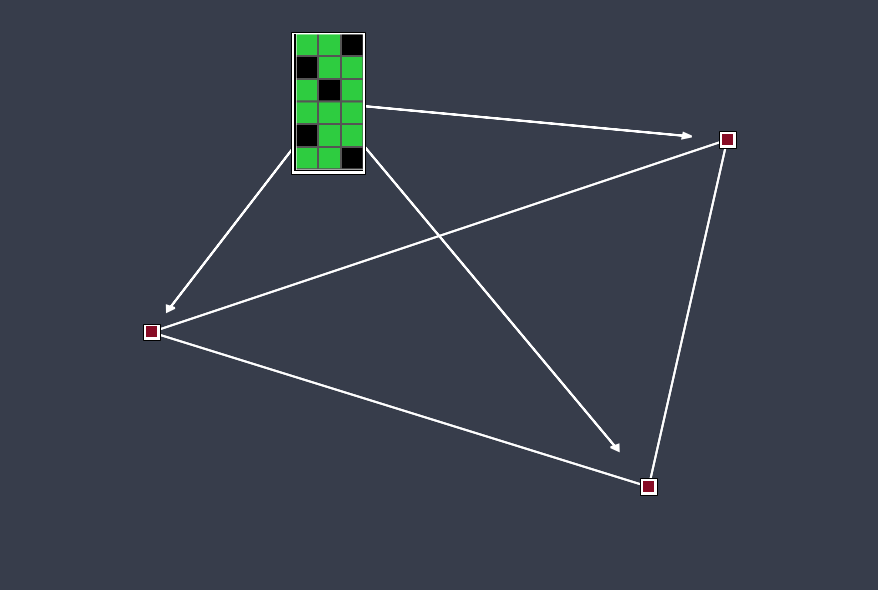

grpah: 5517379512


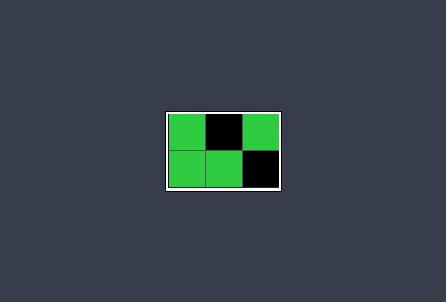

grpah: 5224225368


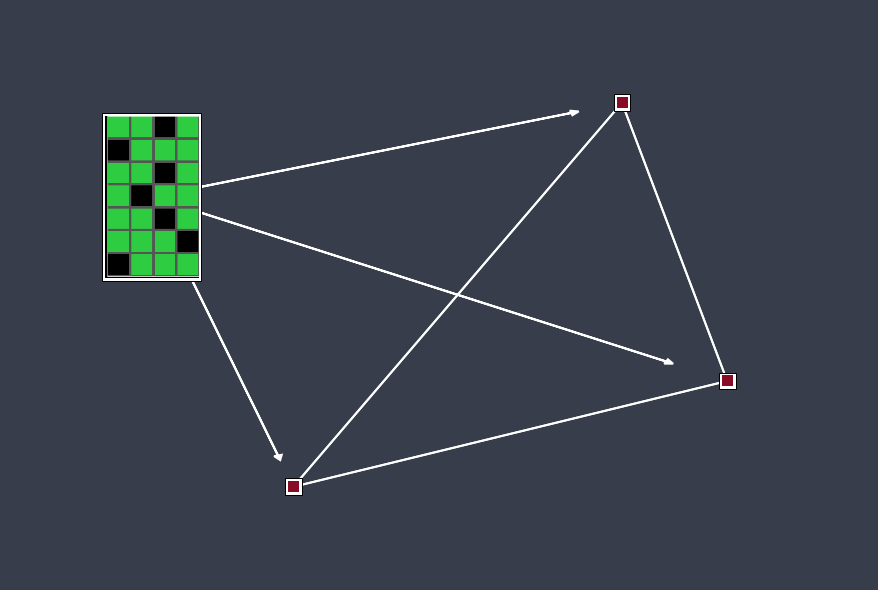

grpah: 5447422080


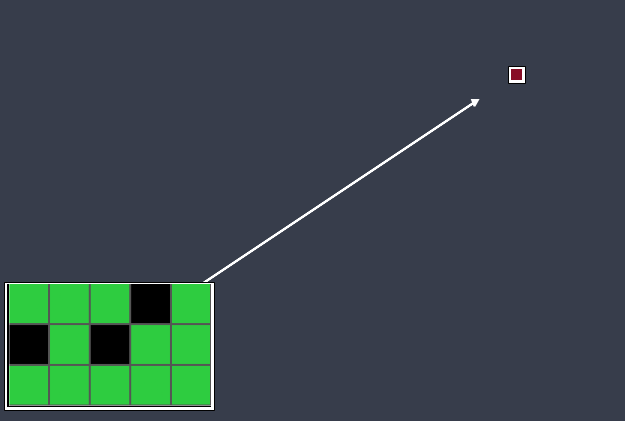

In [354]:
draw_graph(graph); plt.show();
for g in sub_graphs:
    print(f'grpah: {g.name}')
    draw_graph(g); plt.show();

In [313]:

def get_adj_matrix(graph,
                   nodes=None,
                   dtype='float32',
                   order='C'):
    """Returns the adjacency matrix of a graph.
    
    Parameters
    ----------
    graph : Graph
        The NetworkX graph used to construct the NumPy array.
    nodes : list, optional
        The rows and columns are ordered according to the nodes in `nodelist`.
        If `nodelist` is None, then the ordering is produced by G.nodes().
    dtype : NumPy data type, optional
        A valid single NumPy data type used to initialize the array.
        This must be a simple type such as int or numpy.float64 and
        not a compound data type (see to_numpy_recarray)
        If None, then the NumPy default is used.
    order : {'C', 'F'}, optional
        Whether to store multidimensional data in C- or Fortran-contiguous
        (row- or column-wise) order in memory. If None, then the NumPy default
        is used.
    """
    if nodes is None:
        nodes = list(graph)
    if len(set(nodes)) < len(nodes):
        raise ValueError(f'Found duplicates in `nodes`')

    num_nodes = len(nodes)
    node_to_idx = {u.name: i for i, u in enumerate(nodes)}
    
    A = np.zeros((num_nodes, num_nodes), dtype=dtype, order=order)
    for u, nbrs in graph.adjacency():
        for v, edge in nbrs.items():
            A[node_to_idx[u], node_to_idx[v]] = edge.get('weight', 1)

    return A

def scale_layout(pos, scale=1):
    """Returns scaled position array to (-scale, scale) in all axes.
    
    Parameters
    ----------
    pos : numpy array
        positions to be scaled. Each row is a position.
    scale : number (default: 1)
        The size of the resulting extent in all directions.
    Returns
    -------
    pos : numpy array
        scaled positions. Each row is a position.
    """
    # Find max length over all dimensions
    lim = 0  # max coordinate for all axes
    for i in range(pos.shape[1]):
        pos[:, i] -= pos[:, i].mean()
        lim = max(abs(pos[:, i]).max(), lim)
    # rescale to (-scale, scale) in all directions, preserves aspect
    if lim > 0:
        for i in range(pos.shape[1]):
            pos[:, i] *= scale / lim
    return pos


def spectral_pos(graph,
                              k=None,
                              node_to_pos=None,
                              fixed=None,
                              iterations=500,
                              th=1e-4,
                              scale=1,
                              center=None,
                              dim=2,
                              random_state=None):
    """Position nodes using the eigenvectors of the Laplacian."""
    center = np.zeros(dim) if center is None else center
    nodes = list(graph.nodes) # change this later
    num_nodes = len(nodes)
    
    if num_nodes == 0:
        return {}
    if num_nodes == 1:
        return {next(iter(nodes)): center}
    
    if random_state is None:
        random_state = np.random.RandomState(None)
            
    if node_to_pos is not None:
        size = max(1, *[x for pos in node_to_pos.values() for x in pos])
        pos = random_state.rand(num_nodes, dim) * size + center

        for i, node in enumerate(nodes):
            if node in node_to_pos:
                pos[i] = np.asarray(node_to_pos[node])
    else:
        pos = None
        size = 1

    if k is None and fixed is not None:
        k = np.sqrt(size / num_nodes)
        
    pos = _spectral_pos(A=graph.numpy())
    
    if fixed is None and scale is not None:
        pos = scale_layout(pos, scale=scale) + center
    
    return {nodes[i]: pos[i] for i in range(num_nodes)}


def _spectral_pos(A, dim=2):
    num_nodes = len(A)
    # form Laplacian matrix where D is diagonal of degrees
    D = np.identity(num_nodes, dtype=A.dtype) * np.sum(A, axis=1)
    L = D - A

    eigenvalues, eigenvectors = np.linalg.eig(L)
    # sort and keep smallest nonzero
    index = np.argsort(eigenvalues)[1:dim + 1]  # 0 index is zero eigenvalue
    return np.real(eigenvectors[:, index])


def fruchterman_reingold_pos(graph,
                              k=None,
                              node_to_pos=None,
                              fixed=None,
                              iterations=50,
                              th=1e-2,
                              scale=1,
                              center=None,
                              dim=2,
                              random_state=None):
    """Position nodes using Fruchterman-Reingold force-directed algorithm.
    Parameters
    ----------
    G : NetworkX graph or list of nodes
        A position will be assigned to every node in G.
    k : float (default=None)
        Optimal distance between nodes.  If None the distance is set to
        1/sqrt(n) where n is the number of nodes.  Increase this value
        to move nodes farther apart.
    node_to_pos : dict or None  optional (default=None)
        Initial positions for nodes as a dictionary with node as keys
        and values as a coordinate list or tuple.  If None, then use
        random initial positions.
    fixed : list or None  optional (default=None)
        Nodes to keep fixed at initial position.
        ValueError raised if `fixed` specified and `pos` not.
    iterations : int  optional (default=50)
        Maximum number of iterations taken
    th: float optional (default = 1e-4)
        Threshold for relative error in node position changes.
        The iteration stops if the error is below this threshold.
    scale : number or None (default: 1)
        Scale factor for positions. Not used unless `fixed is None`.
        If scale is None, no rescaling is performed.
    center : array-like or None
        Coordinate pair around which to center the layout.
        Not used unless `fixed is None`.
    dim : int
        Dimension of layout.
    Returns
    -------
    pos : dict
        A dictionary of positions keyed by node
    """
    center = np.zeros(dim) if center is None else center
    nodes = list(graph.nodes) # change this later
    num_nodes = len(nodes)
    
    if num_nodes == 0:
        return {}
    if num_nodes == 1:
        return {next(iter(nodes)): center}
    
    if random_state is None:
        random_state = np.random.RandomState(None)
            
    if node_to_pos is not None:
        size = max(1, *[x for pos in node_to_pos.values() for x in pos])
        pos = random_state.rand(num_nodes, dim) * size + center

        for i, node in enumerate(nodes):
            if node in node_to_pos:
                pos[i] = np.asarray(node_to_pos[node])
    else:
        pos = None
        size = 1

    if k is None and fixed is not None:
        k = np.sqrt(size / num_nodes)
        
    pos = _fruchterman_reingold_pos(
        graph.numpy(),
        k=k, 
        pos=pos, 
        fixed=fixed, 
        iterations=iterations,
        th=th, 
        dim=dim, 
        random_state=random_state
    )
    
    if fixed is None and scale is not None:
        pos = scale_layout(pos, scale=scale) + center
    
    return {nodes[i]: pos[i] for i in range(num_nodes)}


def _fruchterman_reingold_pos(X, 
                              k=None,
                              pos=None,
                              fixed=None,
                              iterations=50,
                              th=1e-8, 
                              dim=2,
                              random_state=None):
    
    """Graph Drawing by Force-directed Placement
    (http://faculty.washington.edu/joelross/courses/archive/f14/cs261/lab/j/fruchterman91graph.pdf)
    """
    num_nodes = len(X)
    iterations = 250
    if pos is None:
        if random_state is None:
            random_state = np.random.RandomState(None)
        pos = random_state.rand(num_nodes, dim)
    
    pos = pos.astype(X.dtype)
    k = np.sqrt(np.log(num_nodes))/2 if k is None else k
    t = max(max(pos.T[0]) - min(pos.T[0]), max(pos.T[1]) - min(pos.T[1])) * 0.08
    dt = t / (iterations + 1)
    delta = np.zeros((pos.shape[0], pos.shape[0], pos.shape[1]), dtype=X.dtype)
    
    for _ in range(iterations):
        delta = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
        distance = np.clip(np.linalg.norm(delta, axis=-1), .1, None)
        displacement = np.einsum('ijk,ij->ik',
                                 delta,
                                 (k * k / distance**2 - X * distance / k))
        n = np.linalg.norm(displacement, axis=-1)
        n = np.where(n < .01, .1, n)
        delta_pos = np.einsum('ij,i->ij', displacement, t / n)
        if fixed is not None:
            delta_pos[fixed] = 0.
        pos += delta_pos
        t -= dt
        error = np.linalg.norm(delta_pos) / num_nodes
        if error < th:
            break
            
    return pos

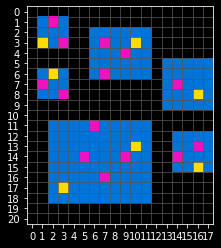

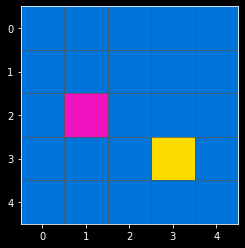

In [315]:
plot_grid(x); plt.show(); plot_grid(y)

grpah: 5310076072


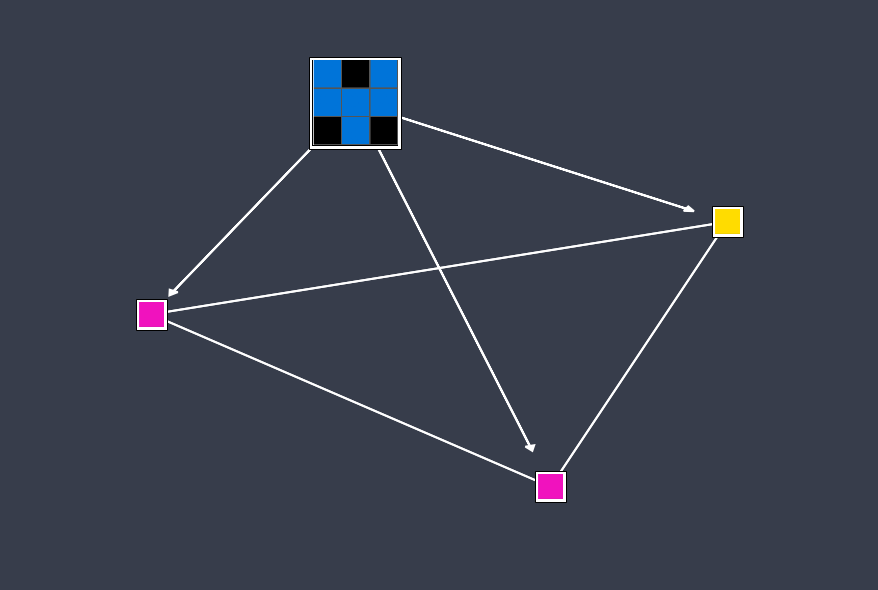

grpah: 5289028968


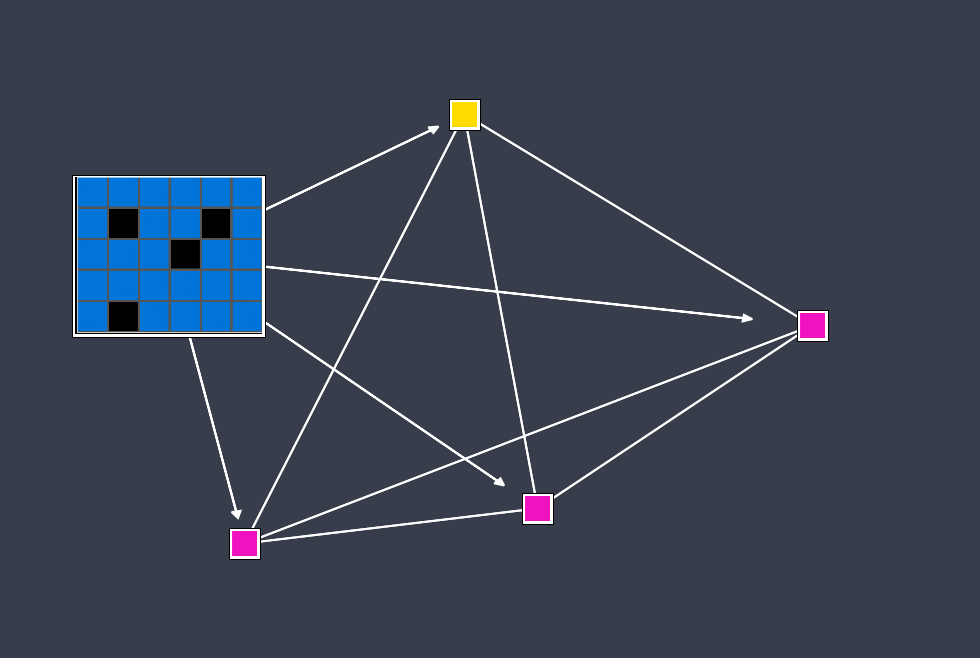

grpah: 5286689704


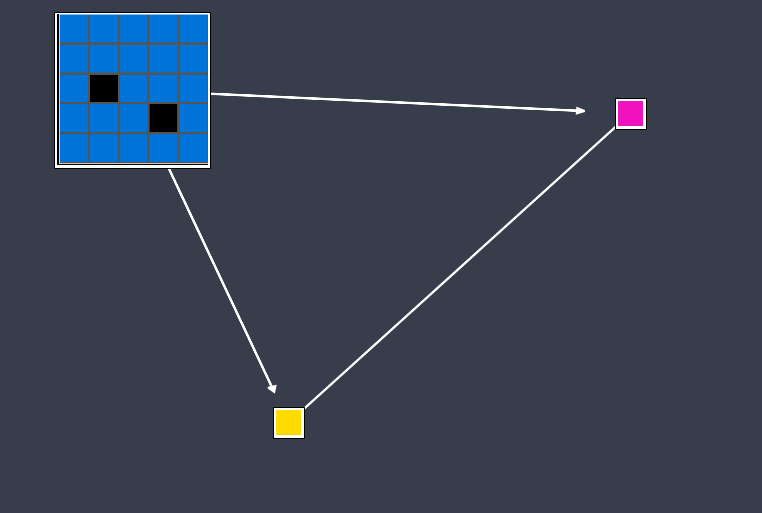

grpah: 5228408504


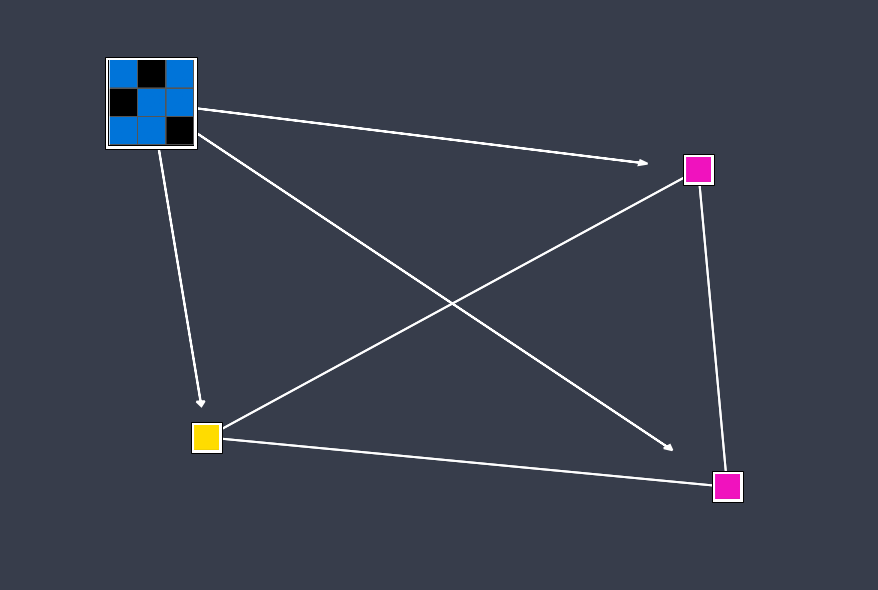

grpah: 5505859312


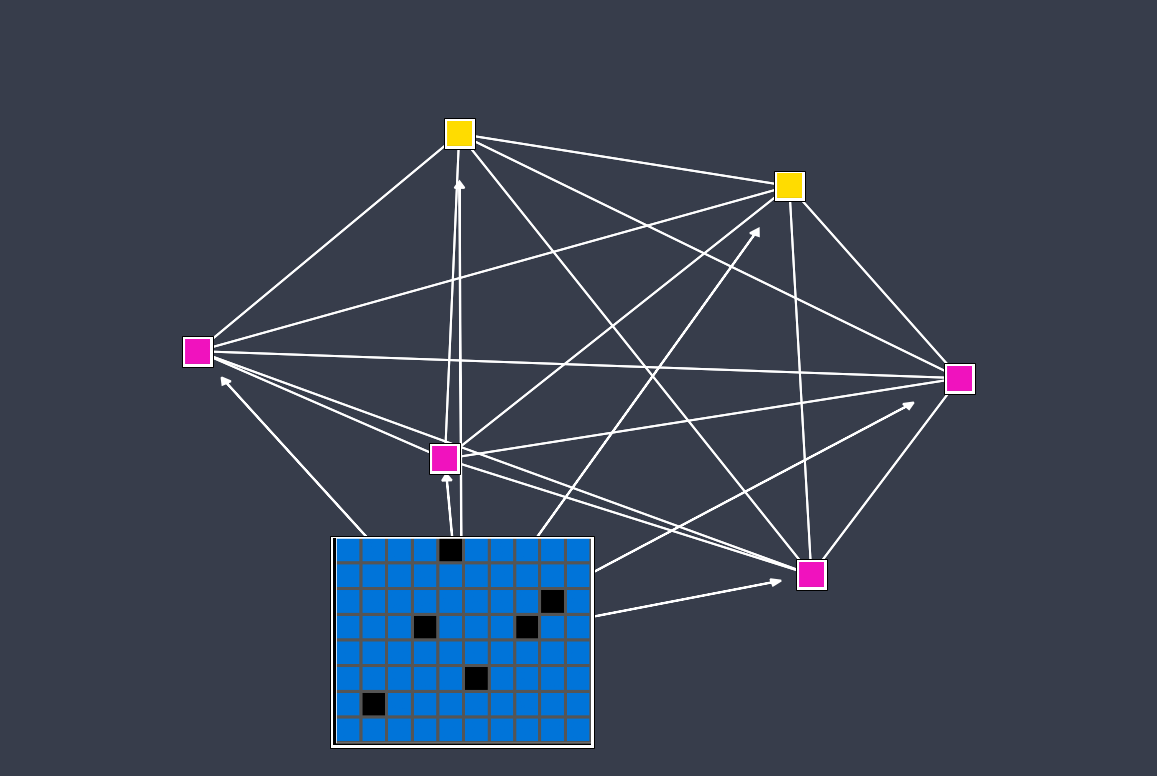

grpah: 5316155432


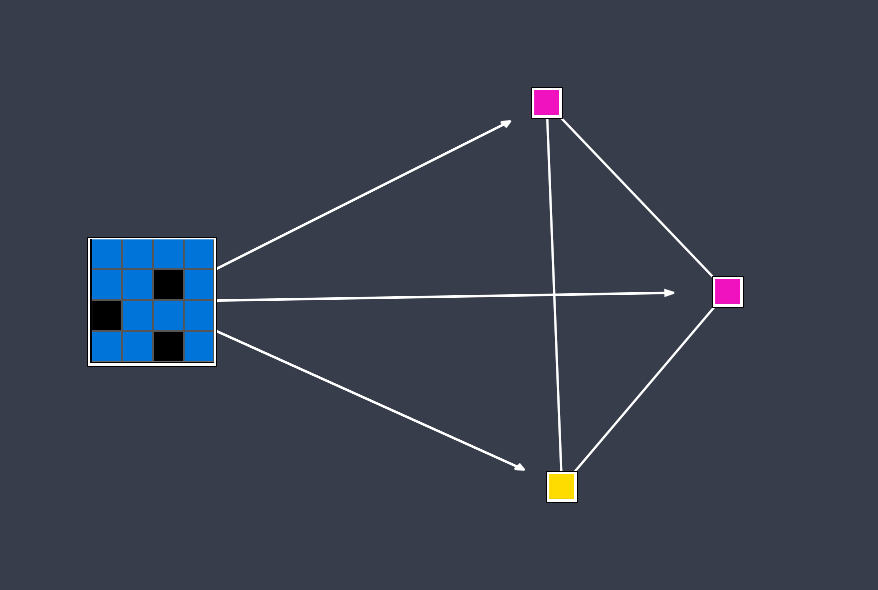

In [314]:
for g in sub_graphs:
    print(f'grpah: {g.name}')
    draw_graph(g); plt.show();

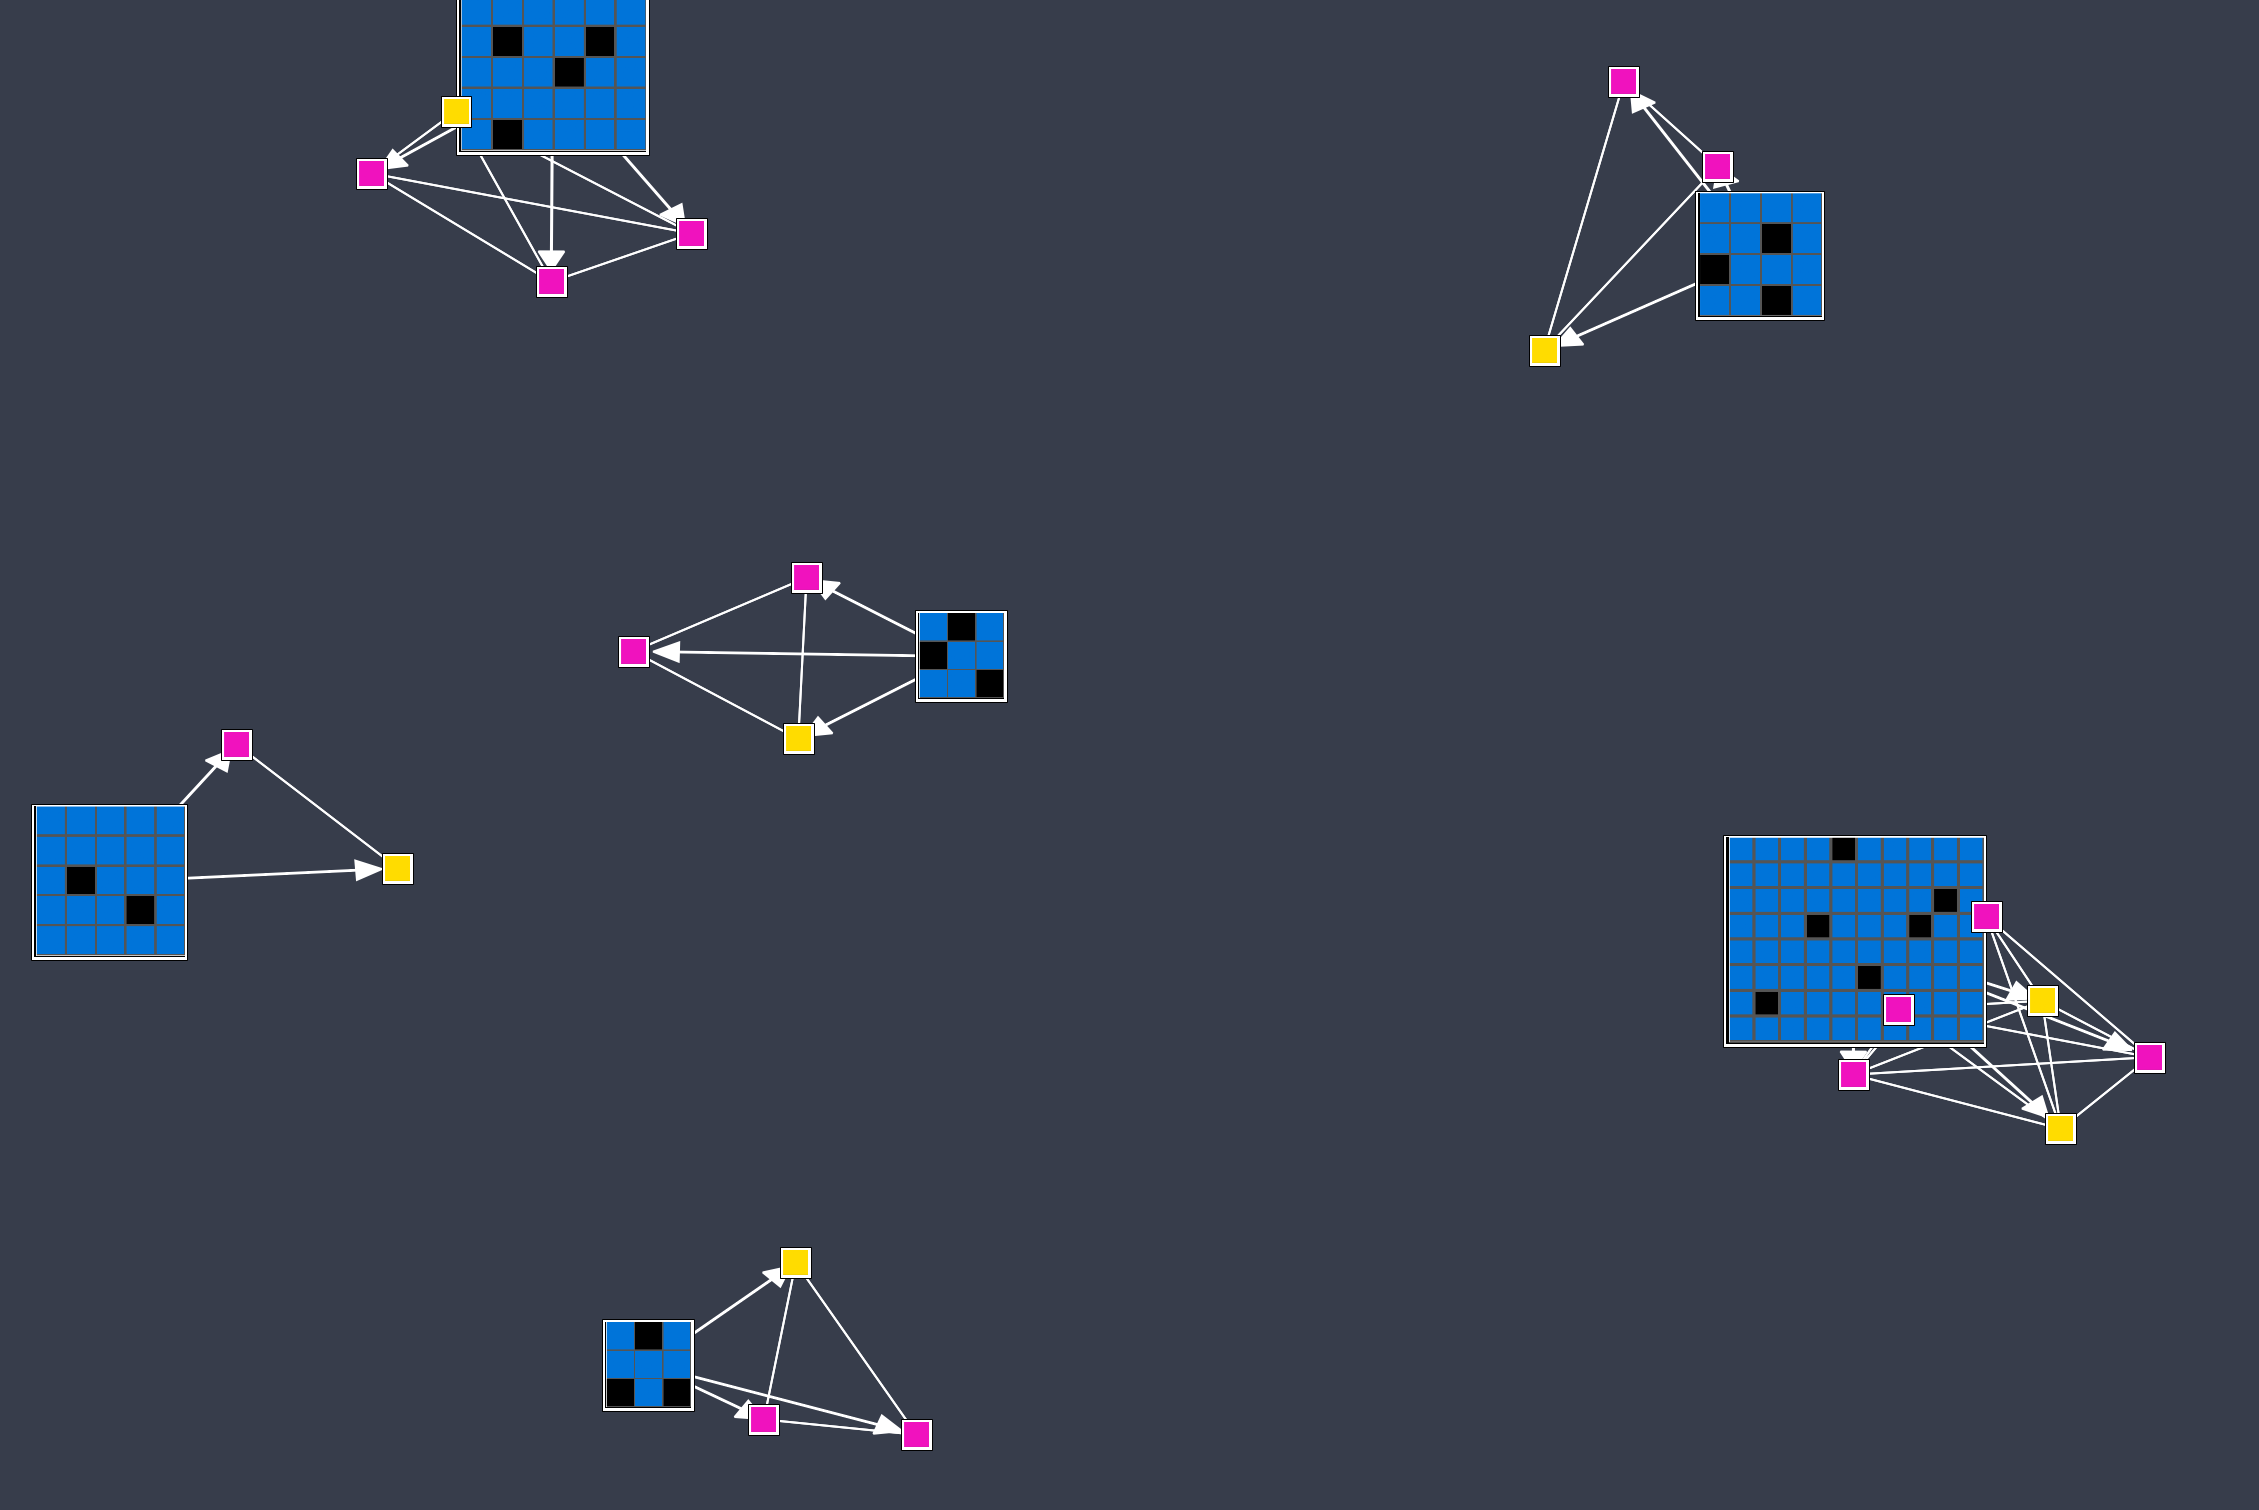

In [280]:
draw_graph(graph)

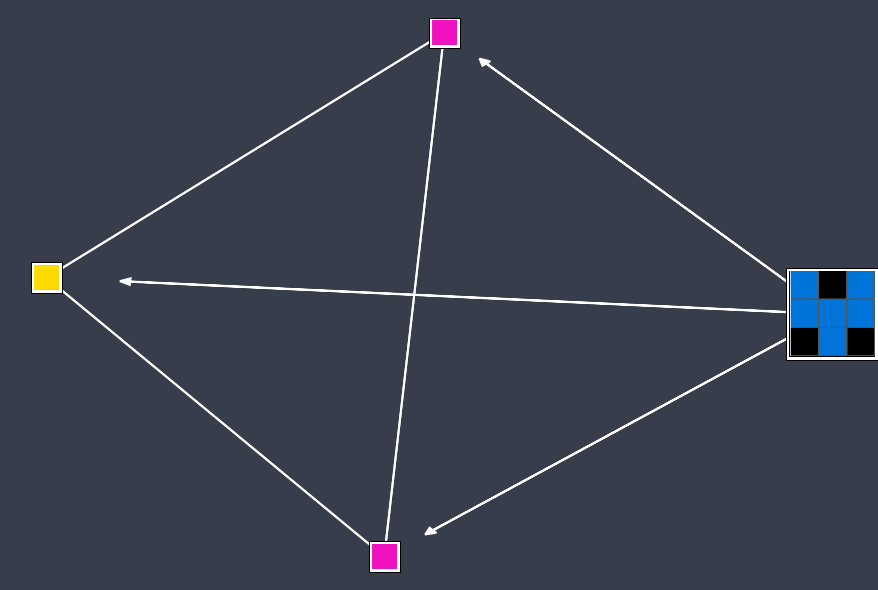

In [281]:
draw_graph(g, )